In [1]:
import sys
import time
import bibtexparser
import itertools
import requests
import re
import matplotlib as plt
import pandas as pd
from bs4 import BeautifulSoup
from tabulate import tabulate
import numpy as np

In [2]:
import bibtexparser
bibtex_file = open('gap-publishednicer.bib.txt', encoding='utf-8')
bib_data = bibtexparser.load(bibtex_file)

In [3]:
bib = bib_data.entries

### Here are the 3 datasets we will start with.

In [84]:
bib_df = pd.DataFrame.from_dict(bib) # large one from the Bibliography
review_df = pd.read_csv('no_citation_text.csv', dtype='str') # MR numbers who came back with no `GAP` text found inside
corpus_df = pd.read_csv('gap_citations_corpus.csv', dtype='str') # CItations scraped from MathSciNet website

# Larger dataset from Bibliography

* how to deal with NaN missing values ? *

We only need some of these columns, hence we `drop` the rest.

In [5]:
bib_df.columns

Index(['printedkey', 'doi', 'url', 'mrreviewer', 'mrnumber', 'mrclass', 'issn',
       'fjournal', 'pages', 'year', 'volume', 'journal', 'title', 'author',
       'ENTRYTYPE', 'ID', 'number', 'school', 'booktitle', 'isbn', 'note',
       'publisher', 'day', 'keywords', 'month', 'series', 'annote', 'type',
       'address', 'institution', 'howpublished', 'editor', 'bookeditor',
       'edition', 'key', 'organization'],
      dtype='object')

In [110]:
bib_df.drop(bib_df.columns[[0, 1, 2, 3, 5, 6, 7, 8, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]], axis = 1, inplace = True)

In [111]:
bib_df.columns

Index(['mrnumber', 'year', 'journal', 'author', 'ENTRYTYPE'], dtype='object')

We reorder the columns.

In [112]:
bib_df = bib_df[['mrnumber', 'author', 'journal', 'year', 'ENTRYTYPE']]

Then we change the `mrnumber` coulmn name to `MR` so we cane later merge this dataframe with the other one.

In [113]:
bib_df.columns = ['MR', 'author', 'journal', 'year', 'ENTRYTYPE']

In [114]:
bib_df

,MR,author,journal,year,ENTRYTYPE
0,4056124,"Abas, M. and Vetrík, T.",Theoret. Comput. Sci.,2020,article
1,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...,2019,article
2,NaN,"Abdeljaouad, I.",RAIRO-INF THEOR APPL,1999,article
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015,article
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and ...",J. Pure Appl. Algebra,2017,article
...,...,...,...,...,...
3362,2647300,"Zusmanovich, P.",J. Geom. Phys.,2010,article
3363,2735394,"Zusmanovich, P.",J. Algebra,2010,article
3364,3201064,"Zusmanovich, P.",J. Algebra,2014,article
3365,3598575,"Zusmanovich, P.",Linear Algebra Appl.,2017,article


Data types and count of non-null values for each columns.

In [11]:
bib_df.info(show_counts  = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MRN        3159 non-null   object
 1   author     3367 non-null   object
 2   journal    3047 non-null   object
 3   year       3367 non-null   object
 4   ENTRYTYPE  3367 non-null   object
dtypes: object(5)
memory usage: 65.8+ KB


Looking at the `MRN` columns, some cells are empty - `NaN`

In [12]:
bib_df.iloc[3274]

MRN                    NaN
author          Wegner, A.
journal                NaN
year                  1989
ENTRYTYPE    mastersthesis
Name: 3274, dtype: object

In [13]:
bib_df.describe()

,MRN,author,journal,year,ENTRYTYPE
count,3159,3367,3047,3367,3367
unique,3158,2511,384,43,10
top,3656296,"Eick, B.",J. Algebra,2017,article
freq,2,18,387,188,2976


### We will look at the `year` column. There are several anomalies and we need just 4 digits in each cell.

In [115]:
bib_df.sort_values('year', ascending=False)

,MR,author,journal,year,ENTRYTYPE
3165,3973299,"Then, H.",NaN,[2019] \copyright 2019,incollection
1546,3898507,"Greer, M.",NaN,[2019] \copyright 2019,incollection
3133,3898514,"Stuhl, I. and Vojtěchovský, P.",NaN,[2019] \copyright 2019,incollection
3147,3782458,"Swinarski, D.",NaN,[2018] \copyright 2018,incollection
1981,4167659,"Kaushik, R. and Yadav, M. K.",J. Algebra,2021,article
...,...,...,...,...,...
3274,NaN,"Wegner, A.",NaN,1989,mastersthesis
2689,NaN,"Niemeyer, A.",NaN,1988,mastersthesis
2673,NaN,"Nickel, W.",NaN,1988,mastersthesis
3018,NaN,"Schönert, M.",NaN,1987,mastersthesis


We will use `.str` and a regular expresion `(r'^(\d{4})'` which first converts all year cells to strings then takes the first 4 digits from each. We then replace the old values with the filtered ones.

In [116]:
bib_df['year'] = bib_df['year'].str.extract(r'^(\d{4})', expand=False)

In [117]:
bib_df['year'].value_counts()

2017    188
2013    175
2018    168
2020    166
2019    165
2010    163
2015    162
2016    158
2014    154
2011    152
2012    142
2007    142
2008    132
2004    131
2005    128
2009    124
2006    118
2001    107
2003    101
2002     84
1999     84
2000     78
1997     76
1998     58
1995     56
2021     39
1996     34
1994     28
1993     25
1992     13
1991      5
1987      2
1988      2
1989      2
1990      1
Name: year, dtype: int64

We inspect the result and no more anomalies are visible. Data type is integer which is also fine.

In [17]:
bib_df['year'].describe()

count     3363
unique      35
top       2017
freq       188
Name: year, dtype: object

Barchart dislaying number of GAP citations per year.

* GAP citation counts for each year, sorted chronologically.

In [18]:
year_chrono = bib_df['year'].value_counts()
chrono_df = year_chrono.to_frame()
chrono = chrono_df.sort_index()
chrono.plot(kind="bar", figsize=(15, 5), title='Annual GAP citations data', xlabel='Years', 
                ylabel='Count', color='purple')

<AxesSubplot:title={'center':'Annual GAP citations data'}, xlabel='Years', ylabel='Count'>

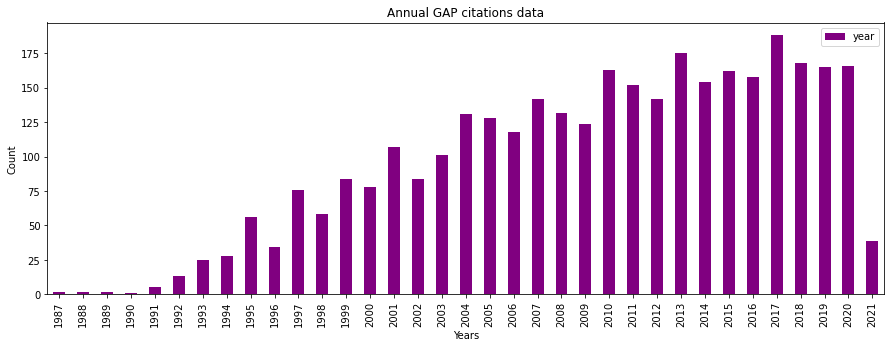

In [19]:
chrono.plot(kind="bar", figsize=(15, 5), title='Annual GAP citations data', xlabel='Years', 
                ylabel='Count', color='purple')

Top 20 journals citing GAP.

In [20]:
top_journals = bib_df['journal'].value_counts()
top_20 = pd.DataFrame(top_journals.head(20))
top_20.reset_index()

,index,journal
0,J. Algebra,387
1,Comm. Algebra,207
2,J. Symbolic Comput.,104
3,Discrete Math.,88
4,J. Algebra Appl.,85
5,J. Group Theory,67
6,Internat. J. Algebra Comput.,64
7,J. Pure Appl. Algebra,64
8,Des. Codes Cryptogr.,59
9,LMS J. Comput. Math.,47


Only for alternative, useful for copy/paste plain text - quick to load.
Try to allign on the left - journals.

In [21]:
headers = ['Journal name', 'GAP Citations count']
print(tabulate(top_20, headers = headers, tablefmt = 'pretty'))

+------------------------------+---------------------+
|         Journal name         | GAP Citations count |
+------------------------------+---------------------+
|          J. Algebra          |         387         |
|        Comm. Algebra         |         207         |
|     J. Symbolic Comput.      |         104         |
|        Discrete Math.        |         88          |
|       J. Algebra Appl.       |         85          |
|       J. Group Theory        |         67          |
| Internat. J. Algebra Comput. |         64          |
|    J. Pure Appl. Algebra     |         64          |
|     Des. Codes Cryptogr.     |         59          |
|     LMS J. Comput. Math.     |         47          |
|     Arch. Math. (Basel)      |         44          |
|     European J. Combin.      |         42          |
|      Experiment. Math.       |         42          |
|         Math. Comp.          |         37          |
|     Electron. J. Combin.     |         35          |
|       Is

In [22]:
bib_df['ENTRYTYPE'].describe()

count        3367
unique         10
top       article
freq         2976
Name: ENTRYTYPE, dtype: object

In [23]:
bib_df['ENTRYTYPE'].value_counts()

article          2976
incollection      204
inproceedings      54
phdthesis          47
mastersthesis      46
book               31
misc                5
techreport          2
inbook              1
manual              1
Name: ENTRYTYPE, dtype: int64

##### The most frequent type of work citing GAP: we can see that GAP is predominantly cited in articles - 2976 times.

In [24]:
types_pub = pd.DataFrame(bib_df['ENTRYTYPE'].value_counts())
types_pub.columns = ['GAP Citations Count']
types_pub.index.names = ['Publication Type']
types_pub

,GAP Citations Count
Publication Type,
article,2976
incollection,204
inproceedings,54
phdthesis,47
mastersthesis,46
book,31
misc,5
techreport,2
inbook,1


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

interact(f, x=['apples','oranges']);

### Top 20 authors citing GAP in their work

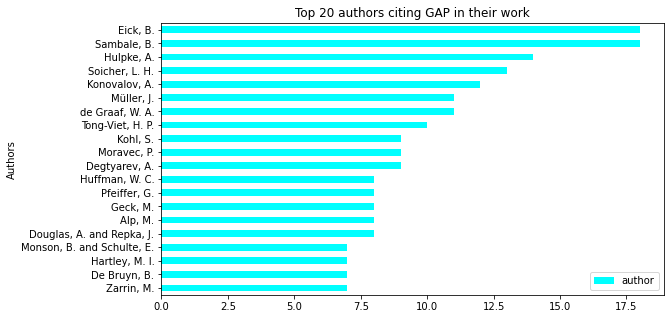

In [25]:
authors = bib_df['author'].value_counts()
top = authors.head(20)
top = top.sort_values(ascending=True)
top = top.to_frame()
chart = top.plot(kind="barh",
                 figsize=(9,5), title='Top 20 authors citing GAP in their work', 
                 xlabel='Authors', 
                 ylabel='Count', color='cyan')


#  Corpus and Review

What are the GAP Citation practices ???
The longer the citation is the more details it contains - measure lenght ?

To do
+ check Citations strings lenghts to isolate too short ones

+ website count citations hacing `gap.com` string to measure how many mention the website
+ remaining HTML characters

Two citations containing Singapore instead of GAP present.



In [44]:
corpus_df

,MR,Citation,Version,Website
0,MR4056124,"GAP – Groups, algorithms, programming - a syst...",None,Yes
1,MR3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.:...",Package,Yes
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and pro...",4.7.5,Yes
3,MR3354065,"The GAP – Groups, Algorithms and Programming. ...",4.4.12,Yes
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg...",4.7.8,Yes
...,...,...,...,...
3537,MR3988630,"M. Delgado, P. A. García-Sánchez and J. Morais...",Package,Yes
3538,MR1801202,"L.H. Soicher, GRAPE: a system for computing wi...",GRAPE GAP Package,Yes
3539,MR2558870,"L. Bartholdi, Functionally recursive groups, h...",None,Yes
3540,MR2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality g...",None,Yes


In [48]:
get_citation('MR2824780') 

('X. Sun, C. Liu, D. Li and J. Gao, On duality gap in binary quadratic programming, Available from: http://www.optimization-online.org/DB_FILE/2010/01/2512.pdf.',
 None)

In [85]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf

def get_citation(mrno):
    r = corpus_df[corpus_df['MR'] == mrno]
    return r.at[r.index[0],'Citation'], r.at[r.index[0],'Version']

In [86]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf
unknown_ver = []
def get_version(s):
    match = re.search("(?:(\d+\.(?:\d+\.)*\d+))", s, re.IGNORECASE)
    if match != None:
        return match.group(1)
    else:
        print('No match:', s)
        unknown_ver.append(s)

In [87]:
def is_package(series):
    mrno = series['MR']
    citation = series['Citation']
    version = series['Version']
    if re.search("package", citation, re.IGNORECASE) != None:
        print('***Package***:', mrno, citation)
        return 'Package'
# this way we catch cases where GRAPE is used without the word package
    elif re.search("grape", citation, re.IGNORECASE) != None: 
        print('??? GRAPE PKG ???:', mrno, citation)
        return 'GRAPE GAP Package'
    else:
        print('***Not a Package***:', mrno, citation)
        return series['Version']

In [88]:
def website_check(series):
    mrno = series['MR']
    citation = series['Citation']
    version = series['Version']
    if re.search("www|\.net|http", citation, re.IGNORECASE) != None:
        print('***Provided Website***:', mrno, citation)
        return 'Yes'
    else:
        print('***Not Provided***:', mrno, citation)
        return 'No'

First we create the version column. Then we fill its cells with the version, where provided.

In [89]:
corpus_df.insert(loc=2, column='Version', value=' ')

In [90]:
corpus_df['Version'] = corpus_df['Citation'].map(get_version)

No match: GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
No match: Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
No match: M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [10].
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [8].
No match: Gamble, G., Nickel, W., O'Brien, E.A.: ANU p-Quotient–p-Quotient and p-Group Generation Algorithms (2006). An accepted GAP 4 package, available also in MAGMA
No match: M. Schönert et al, GAP: groups, algorithm and programming, © 1992 by Lehrstuhl D für Mathematik, distributed with the GAP software via ftp from samson.math.rwth-aachen.de.
No match: M. Delgado, P. A. G

No match: B. Eick, W. Nickel, Polycyclic–Computing with polycyclic groups, 2002. A GAP Package, see [16]. 
MR1829476
No match: W. Nickel, $\roman{np}$–Nilpotent Quotients of Finitely Presented Groups, 2003. A GAP Package, see [16].
No match: B. Eick and W. Nickel. Polycyclic - Computing with polycyclic groups, 2002. A GAP Package, see [12]. 
MR1829476
No match: W. Nickel, nq - Nilpotent Quotients of Finitely Presented Groups, 2003. A GAP Package, see [12].
No match: M. Bocheński, P. Jastrzȩbski, and A. Tralle, CKForms. A GAP Package. Avaiable online (https://pjastr.github.io/CKForms/).
No match: W. A. de Graaf, SLA-Computing with Simple Lie Algebras, A GAP Package. Available online (http://www.science.unitn.it/degraaf/sla.html).
No match: M. Schönert et. al., GAP – Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, fifth edition, 1995.
No match: M. Schönert, et al., GAP—Groups, Algorithms, and Programming, 5th

No match: M. Costantini, W.A. de Graaf, C. Schneider, liealgdb, a database of Lie algebras, a GAP4 package, 2006, in preparation.
No match: Bettina Eick, Werner Nickel, Polycyclic, a GAP package, http://www.gap-system.org/Packages/polycyclic.html, 2004 (accepted).
No match: W.A. de Graaf, SLA - computing with Simple Lie Algebras, a GAP package, http://science.unitn.it/$\sim$degraaf/sla.html, 2009.
No match: de Graaf, W.A., 2009. SLA—computing with Simple Lie Algebras. A GAP package, (http://science.unitn.it/$\sim$degraaf/sla.html).
No match: de Graaf, W.A.: SLA–Computing with Simple Lie Algebras. A GAP Package (2009). http://science.unitn.it/$\sim$degraaf/sla.html
No match: Willem A. de Graaf, SLA–Computing with simple Lie algebras. A GAP package, http://science.unitn.it/$\sim$degraaf/sla.html, 2009.
No match: The GAP Group, GAP - Groups, Algorithms and Programming, http://www.gap-system.org,2000.
No match: Dietrich, H., Faccin, P., de Graaf, W.A., 2012. CoReLG - computing with real Li

No match: M. Horn, B. Eick, GroupExt - Constructing finite groups, 2013, a GAP 4 package, see [28].
No match: M. Neunhoeffer, F. Noeske, Genss - Generic Schreier—Sims, 2012, A GAP 4 package, see [28].
No match: C. Sievers, FGA - Computing with free groups, 2003, a refereed GAP 4 package, see [28].
No match: H.U. Besche, B. Eick, E. O'Brien, SmallGroups — a library of groups of small order, 2005. A refereed GAP 4 package, see [14].
No match: T. Moede. "Coclass Graphs for Nilpotent Associative Algebras." A GAP 4 package, see [The GAP Group 05], available online (http://www.icm.tubs.de/~tobmoede/ccalgs/), 2015.
No match: V. Felsch and F. Gähler, CrystCap – A libarary of crystallographic groups. A refereed GAP 4 package, 2000.
No match: H.U. Besche, B. Eick, E. O'Brien, Small Groups – a library of groups of small order. A GAP 4 package. Webpage available at www.icm.tu-bs.de/ag_algebra/software/small/small.html, 2005.
No match: M. Vaughan-Lee, B. Eick, LiePRing – Database and Algorithms for

No match: G. Havas, C. Ramsay, G. Gamble, and A. Hulpke. "ACE: A GAP 4 Package Providing an Interface to the Advanced Coset Enumerator." Available from World Wide Web (http://www.gap-system.org/Share/ace.html), 2003.
No match: Gamble, G., Havas, G., Hulpke, A. (2002). PGRelFind: a GAP example using the ACE share package. {http://www.gap-system.org/-gap/Intro/pgrelfind.html} (accessed September 2002).
No match: Nickel, W., 1988. Endliche Körper in dem gruppentheoretischen Programmsystem GAP. Diploma Thesis, RWTH Aachen.
No match: The GAP Group, 1997. GAP–groups, algorithms, and programming, Version 4. Lehrstuhl D für Mathematik, RWTH Aachen, Germany and School of Mathematical and Computational Sciences, U. St. Andrews, Scotland.
No match: A. M. Cohen, J.W. Knopper, GBNP, A GAP Package for Gröbner Bases of Noncommutative Polynomials, available at http://dam02.win.tue.nl/products/gbnp/.
No match: M. SCHO NERT et al., GAP – groups, algorithms, and programming (RWTH Aachen, 1994).
No match:

No match: Martin Schönert et al. GAP–Groups, Algorithms, and Program- ming. Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, third edition, 1993–1997.
No match: Lübeck, F. (1999). EDIM—Elementary Divisors and Integer Matrices, RWTH Aachen, Lehrstuhl D für Mathematik, (a refereed share package for GAP (1999), see http://www.gap-system.org/share/edim.html).
No match: M. Schönert et al., GAP - Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, RWTH Aachen, Germany, 1995.
No match: The GAP Group, `GAP–Groups, Algorithms, and Programming, Version 4', Aachen, St Andrews, 1998, (http://www-gap.dcs.st-and.ac.uk/gap).
No match: Besche H U, Eick B and O'Brien E A 2002 SmallGroups—a GAP package http://www.gap-system.org/Packages/sgl.html, http://www-public.tu-bs.de:8080/~beick/soft/small/small.html
No match: GAP—Groups, Algorithms, Programming—A System for Computational Discrete Algebra. https://www.gap-system.org
No match: M. Schönert et al

No match: M. Schönert et al., GAP - Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, fourth edition, 1994.
No match: M. Delgado, P.A. García-Sánchez, J.J. Morais, GAP numerical semigroups package, http://www.gap-system.org/Manuals/pkg/numericalsgps/doc/manual.pdf.
No match: M. Delgado, P. A. García-Sánchez, J. J. Morais, GAP Numerical Semigroups Package, http://www.gap-system.org/Manuals/pkg/numericalsgps/doc/manual.pdf.
No match: GAP Group: Groups, Algorithms and Programming, Version 4. 4. 6. Retrieved on July 30 2009 from: \underline{http://www.gap-system.org/Download/index.html.}
No match: M. Schönert et al., GAP—Groups, Algorithms, and Programming, 5th ed., Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen (1995).
No match: The GAP Group, GAP—Groups, algorithms, and programming, http://www.gapsystem.org.
No match: M. Schönert et al. GAP—Groups, Algorithms and Programming. L

No match: Delgado, M., García-Sanchez, P., Morais, J. (2013). Gap package numericalsgps. http://www.gap-system.org/Packages/numericalsgps.html, June 2013.
No match: CARAT, http://www.gap-system.org/Packages/carat.html
No match: http://www.gap-system.org.
No match: Ellis, G.: HAP–Homological Algebra Programming. http://www.gap-system.org/Packages/hap.html. Accessed 04 Nov 2016
No match: Groups, Algorithms, Programming – A System for Computational Discrete Algebra, http://www.gap-system.org/.
No match: Schönert M. et al., Groups, Algorithms, and Programming, Lehrstuhl D. für Mathematik, RWTH. Aachen (1994). (http://www.gap-system.org/).
No match: Kargapolov M. I. and Merzlyakov Yu. I., Fundamentals of the Theory of Groups, Springer-Verlag, New York; Heidelberg; Berlin (1979). 
MR0551207
No match: Schönert M. et al., Groups, Algorithms and Programming (1997), http://www-gap.dcs.st-and.ac.uk/gap.
No match: Groups, algorithms and programming, Lehrstuhl $\roman{D}$ für Mathematik, RWTH Aache

In [91]:
corpus_df['Version'].value_counts()

4.4         460
4.4.12      310
4.3         232
4.4.10      136
4.2         127
           ... 
4.08.10       1
2.8           1
10.01.16      1
1.13          1
4.7.3         1
Name: Version, Length: 196, dtype: int64

Then we apply the function which chekcs if it is a case of citing GAP Package. Packages are connected to GAP, but technically is a separate piece of software. In entries citing GAP package there is no version of GAP provided hence we will fill the `Version` cell with `Package`.

In [92]:
corpus_df['Version'] = corpus_df.apply(is_package,axis=1)

***Not a Package***: MR4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
***Package***: MR3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
***Not a Package***: MR3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
***Not a Package***: MR3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
***Not a Package***: MR3646312 The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
***Not a Package***: MR1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
***Not a Package***: MR2287843 The G

***Not a Package***: MR2401559 The GAP group, GAP, Aachen, St. Andrews, http:www-gap.dcs.st-and.ac.uk/gap, 1999.
***Not a Package***: MR2303162 The GAP Group, GAP—Groups, Algorithms and Programming, Version 4.3, Aachen, St Andrews, 2003, <http://www.gap-system.org>.
***Not a Package***: MR2404644 The GAP Group, GAP - Groups, Algorithms and Programming, Version 4.2, Aachen, St. Andrews, 2000, (http://www-gap.dcs.st-and.ac.uk/-gap).
***Not a Package***: MR2660431 The GAP Group, GAP — Groups, Algorithms and Programming (Version 4.2), Aachen, St Andrews, 2000 (http://www-gap.dcs.st-and.ac.uk/~gap).
***Not a Package***: MR2923663 The GAP Group, $\Bbb{GAP}$ - Groups, Algorithms and Programming, Version 4.3, Aachen, St Andrews, 2002, (http://www.gap-system.org).
***Not a Package***: MR3293591 The GAP Group, $\Bbb{G}\Bbb{A}\Bbb{P}$ - Groups, Algorithms and Programming, Version 4.3, Aachen, St. Andrews, 2003, (http://www.gap-system.org).
***Not a Package***: MR3943349 F. Ali, M. Al-Kadhi, A. Al

***Not a Package***: MR3677868 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.8 (2015). http://www.gap-system.org.
***Not a Package***: MR2799090 The GAP Group. GAP-Groups, Algorithms, and Programming, version 4.4.12, http://www.gap-system.org. 2008.
***Package***: MR2799090 M. Graña and L. Vendramin, RiG, A GAP package for racks and Nichols Algebras, available at http://mate.dm.uba.ar/~lvendram.
***Not a Package***: MR2745542 T. Breuer, The GAP Character Table Library, Version 1.2 (unpublished), http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/ctbllib/.
***Not a Package***: MR2745542 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12, 2008, available at http://www.gapsystem.org.
***Package***: MR2745542 R.A. Wilson, R.A. Parker, S. Nickerson, J.N. Bray, T. Breuer, AtlasRep, A GAP Interface to the ATLAS of Group Representations, Version 1.4, refereed GAP package, http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/atlasrep, 2007.
***Not a P

***Not a Package***: MR2726572 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.10, 2007, http://www.gap-system.org.
***Not a Package***: MR3320863 GAP: groups, algorithms, and programming, Version 4.4.12, The GAP Group, 2008, available at http://www.gap-system.org.
***Not a Package***: MR4125845 F. Effenberger and J. Spreer, simpcomp–GAP toolkit for simplicial complexes, version 1.3.3, (2010), https://simpcomp-team.github.io/simpcomp/.
***Not a Package***: MR4125845 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.8.4, (2016), http://www.gap-system.org.
***Not a Package***: MR3921334 The GAP group: GAP - Groups, Algorithms, and Programming. Available at http://www.gap-system.org/
***Package***: MR3544422 H. U. Besche, B. Eick and E. A. O'Brien, The Small Groups Library — a library of groups of small order, (2005); an accepted and refereed GAP 4 package, available also in MAGMA.
***Package***: MR3544422 G. Gamble, W. Nickel and E. A. O'Brien, ANU $

***Package***: MR3261464 Mohamed Barakat, Markus Lange-Hegermann, The homalg package—A homological algebra GAP4 meta-package for computable Abelian categories, http://homalg.math.rwth-aachen.de/index.php/core-packages/homalg-package, 2007–2014.
***Not a Package***: MR1473430 GAP, Lehrstuhl D fuer Mathematik, RWTH Aachen http://www.ccs.neu.edu/mirrors/GAP.
***Not a Package***: MR2003626 GAP: Groups, Algorithms and Programming, A computer program available from http://www.dcs.stand.ac.uk/gap.
***Package***: MR4113853 B. Eick, H. U. Besche and E. O'Brien, SmallGrp – A GAP package, version 1.3 (2018), https://www.gap-system.org/Packages/smallgrp.html.
***Not a Package***: MR4113853 The GAP Group, Groups Algorithms and Programming, version 4.10.2 (2019), http://www.gap-system.org.
***Not a Package***: MR1700514 M. Schönert et al., "GAP Groups, Algorithms and Programming, Lehrstuhl D für Mathematik, RWTH Aachen, 1992.
***Not a Package***: MR2608962 The GAP Group. GAP—Groups, Algorithms, and 

***Not a Package***: MR1935567 The GAP Team, GAP—Groups, Algorithms, and Programming, Version 4, Lehrstuhl D für Mathematik, RWTH Aachen and School of Mathematical and Computational Sciences, University of St Andrews, 2000.
***Not a Package***: MR2081924 M. Schönert et al., GAP—Groups, Algorithms, and Programming, 5th ed., Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 1995.
***Not a Package***: MR2225499 M. Schönert et al., GAP – groups, algorithms, and programming, Lehrstuhl D für Mathematik, 5th edn (Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 1995).
***Not a Package***: MR3565438 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.5.6, http://www.gapsystem.org, 2012.
***Not a Package***: MR3720803 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.7.4, http://www.gapsystem.org,2014.
***Not a Package***: MR4108336 The GAP Group, GAP – groups, algorithms, and programming, http://www.gap-sy

***Package***: MR3054572 Y. Muntyan and D. Savchuk, AutomGrp—GAP package for computations in self-similar groups and semigroups. Available at http://finautom.sourceforge.net/
***Package***: MR3830835 H. U. Besche, B. Eick, and E. O'Brien, "GAP: The Small Groups Library", software package, 2002, available at https://www.gap-system.org/Packages/sgl.html.
***Not a Package***: MR2009393 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.2, Aachen, St. Andrews, 2000. Available from http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Not a Package***: MR1871679 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.1; Aachen, St. Andrews, 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Not a Package***: MR1925146 The GAP group, The GAP4 Reference Manual, St. Andrews and Aachen, 1998.
***Not a Package***: MR3227979 The GAP Group, GAP—groups, algorithms, and programming, version 4.7.4; 2014. (http://www.gap-system.org).
***Not a Package***: MR3897218 The GAP Group. GA

***Not a Package***: MR3682588 R. A. Wilson et al., $\ssf{AtlasRep}$, a $\ssf{GAP}$ Interface to the Atlas of Group Representations, Version 1.5.1; 2016, http://www.math.rwth-aachen.de/~Thomas.Breuer/atlasrep.
***Package***: MR3985485 T. Breuer, CTblLib, The GAP Character Table Library, a GAP package, Version 1.2.2 (released 07/03/2013), http://www.gap-system.org/Packages/ctbllib.html, http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib/.
***Not a Package***: MR3985485 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.9.2; 2018, https://www.gap-system.org.
***Package***: MR3985485 L. Maas and F. Noeske, {\ssf moc, MOC} for {\ssf GAP}, unreleased GAP package.
***Package***: MR3985485 J. Michel, The development version of the CHEVIE package of GAP3, J. Algebra 435 (2015), 308–336, DOI 10.1016/j.jalgebra.2015.03.031. MR3343221 
MR3343221
***Not a Package***: MR4102117 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.10, https://www.gap-system.org, 

***Package***: MR3578995 Rahm, A.D., Sánchez-García, R.J.: GAP implementation of the Davis complex (2015). http://www.gap-system.org/Packages/hap.html
***Not a Package***: MR2537674 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2006.
***Not a Package***: MR2970863 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4; 2006. (http://www.gap-system.org)
***Not a Package***: MR3733962 The GAP Group, "GAP: groups, algorithms, and programming", software, 2015, http://www.gap-system.org. Version 4.7.8.
***Not a Package***: MR2852489 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.4.12, 2008, http://www.gap-system.org.
***Not a Package***: MR3492040 The GAP Group, GAP — Groups, Algorithms, and Programming, Version 4.6.4 (2013), http://www.gap-system.org.
***Package***: MR3492040 W. de Graaf, SLA — a GAP package, 0.13, 2013, http://www.science.unitn.unitn.it/~degraaf/sla.html.
***Not a Package***: MR3807058 The

***Not a Package***: MR2367323 The GAP Group. "GAP—Groups, Algorithms, and Programming, Version 4.4." Available online (http://www.gap-system.org/), 2004.
***Not a Package***: MR2367323 The GAP Group. "Balanced Presentations for Covering Groups of Simple Groups." Available online (http://www.gap-system.org/Doc/Examples/balanced.html), 2004.
***Package***: MR1998050 Gamble, G., Havas, G., Hulpke, A. (2000a). PGRelFind: a GAP example using the share package ACE. http://www-gap.dcs.st-and.ac.uk/$\sim$gap/Intro/pgrelfind.html.
***Not a Package***: MR1998050 Gamble, G., Havas, G., Hulpke, A., Ramsay, C. (2000b). ACE: a GAP 4 interface to the Advanced Coset Enumerator of $G$, Havas and C. Ramsay, http://www-gap.dcs.st-and.ac.uk/$\sim$gap/Share/ace.html.
***Not a Package***: MR1998050 The GAP Group, Aachen, St Andrews, GAP–Groups, Algorithms, and Programming, Version 4.2, 2000. http://www-gap.dcs.st-and.ac.uk/$\sim$gap/.
***Package***: MR2118175 Greg Gamble, Alexander Hulpke, George Havas and

***Package***: MR2999246 G.P. Nagy, P. Vojtěchovský, LOOPS: Computing with Quasigroups and Loops, version 2.1.0, package for GAP, http://www.math.du.edu/loops.
***Not a Package***: MR3135703 GAP - Groups, Algorithms, Programming - a System for Computational Discrete Algebra, http://www.gap-system.org.
***Not a Package***: MR3609847 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.4; 2014. http://www.gap-system.org
***Not a Package***: MR4036497 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.7.4 (2014). http://www.gap-system.org
***Not a Package***: MR4076812 The GAP Group, "GAP: groups, algorithms, and programming", 2017, available at https://www.gap-system.org. Version 4.8.8.
***Not a Package***: MR2112527 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3 (http://www.gap-system.org), 2002.
***Not a Package***: MR2102447 The GAP Group. (2002). GAP–Groups, Algorithms, and Programming, Version 4.3; http://www.gap-system.org.
***No

***Not a Package***: MR2884238 The GAP Group, GAP—groups, algorithms, programming. Version 4.4.10, 2007. http://www.gap-system.org
***Not a Package***: MR3894326 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.6, https://www.gap-system.org, 2017.
***Not a Package***: MR2229881 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org (2004).
***Not a Package***: MR2031313 GAP—Groups, Algorithms, and Programming, Version 4.2 (2000); http://www.gap-system.org.
***Not a Package***: MR2753303 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4.9, http: //www-gap.des.st-and.ac.uk/gap/, 2006.
***Package***: MR2753303 L. H. Soicher, The GRAPE package for GAP, Version 4.3, http://www.maths.qmul.ac.uk/$\sim$leonard/grape/+, 2006.
***Not a Package***: MR3100304 The GAP Group, GAP Groups, Algorithms, and Programming, Version 4.4.9; 2006. (http://www.gap-system.org)
***Package***: MR3100304 L. H. Soicher, DESIGN - a GAP pac

***Not a Package***: MR2944435 The GAP Group: GAP–Groups, Algorithms, and Programming, Version 4.4 (2004). http://www.gap-system.org
***Package***: MR2944435 de Graaf, W.A.: SLA–Computing with Simple Lie Algebras. A GAP Package (2009). http://science.unitn.it/$\sim$degraaf/sla.html
***Not a Package***: MR2975387 The GAP Group, GAP–Groups, algorithms, and programming, Version 4.4, http://www.gap-system.org, 2004.
***Package***: MR2975387 Willem A. de Graaf, SLA–Computing with simple Lie algebras. A GAP package, http://science.unitn.it/$\sim$degraaf/sla.html, 2009.
***Package***: MR3768261 B. Eick and T. Moede, ccalgs — version 1.0 — a $\ssf{GAP}$ package (2015), http://www.icm.tu-bs.de/tobmoede/ccalgs/.
***Not a Package***: MR3768261 The GAP Group, GAP — Groups, Algorithms, and Programming, version 4.8.5 (2016).
***Not a Package***: MR2257255 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, http://www. gap-system.org (2002). 202 DE KLERK, MAHARRY, PASECHNIK, RICHTER,

***Package***: MR3283749 Heiko Dietrich, Paolo Faccin, Willem A. de Graaf, Corelg: computing with real Lie groups, A GAP 4 package, available at science.unitn.it/$\sim$corelg/.
***Package***: MR3283749 Heiko Dietrich, Paolo Faccin, Willem A. de Graaf, A GAP package for computing with real semisimple Lie algebras, in: H. Hong, C. Yap (Eds.), ICMS 2014, in: Lecture Notes in Comput. Sci., vol. 8592, Springer, Heidelberg, 2014, pp. 59–66. 
MR3334745
***Not a Package***: MR3283749 The GAP Group, GAP–groups, algorithms, and programming, v.4.7.2, available at gap-system.org.
***Not a Package***: MR3619127 H. Dietrich, B. Eick and D. Feichtenschlager, Investigating $p$-groups by coclass with GAP, in: Computational Group Theory and the Theory of Groups (Davidson 2007), Contemp. Math. 470, American Mathematical Society, Providence (2008), 45–61. 
MR2478413
***Not a Package***: MR3619127 GAP – Groups, Algorithms and Programming, http://www.gap-system.org.
***Package***: MR2478413 H. U. Besehe, B.

***Not a Package***: MR2902724 Draisma, J.: blattner, an implementation of the realisation formula. GAP-code: http://www.win.tue.nl/$\sim$jdraisma/index.php?location=programs
***Not a Package***: MR2902724 The GAP Group.: GAP—Groups, Algorithms, and Programming, Version 4.3. http://www.gap-system.org (2002)
***Not a Package***: MR2234814 The GAP Group, GAP—Groups, algorithms, and programming, Version 4.3; St. Andrews, Aachen, 1999. (Visit http://www-gap.dcs.st-and.ac.uk/$\sim$gap). The GAP libraries specific to this paper are available at: http://www.math.du.edu/$\sim$petr in section research| computing.
***Not a Package***: MR2431758 The GAP Group, GAP - Groups, Algorithms, and Programming, version 4.4.9, 2006. http://www.gap-system.org.
***Package***: MR2431758 G.P. Nagy, P. Vojtěchovský, LOOPS: Computing with quasigroups and loops, version 1.5.0, package for GAP. Distribution website: http://www.math.du.edu/loops.
***Not a Package***: MR2818949 The GAP Group. GAP Groups, Algorithms,

***Not a Package***: MR3641681 The GAP Group, GAP – Groups, Algorithms and Programming, Version 4.4, available from http://www.gap-system.org, 2005.
***Not a Package***: MR3780008 The GAP Group, GAP – Groups, Algorithms and Programming, Version 4.4. Available from http://www.gap-system.org, 2005.
***Package***: MR3807061 H.U. Besche, B. Eick, E. O'Brien, Small Groups – a library of groups of small order. A GAP 4 package. Webpage available at www.icm.tu-bs.de/ag_algebra/software/small/small.html, 2005.
***Package***: MR3807061 B. Eick, T. Moede, pnqporc, a GAP 4 package. Available at http://www.icm.tu-bs.de/~tobmoede/pnq/pnqporc-1.0.tar.gz, 2017.
***Not a Package***: MR3807061 The GAP Group, GAP – Groups, Algorithms and Programming, version 4.4. Available from http://www.gap-system.org, 2005.
***Package***: MR3807061 M. Vaughan-Lee, B. Eick, LiePRing – Database and Algorithms for Lie p-Rings, 2015. A GAP 4 package, see [22].
***Not a Package***: MR4044696 The GAP Group, GAP – groups, al

***Not a Package***: MR3893366 GAP The GAP Group, GAP — Groups, Algorithms, and Programming, Version 4.9.2, http://www.gap-system.org, 2018.
***Not a Package***: MR3893366 R.A. Wilson, R.A. Parker, S. Nickerson, J.N. Bray, T. Breuer, AtlasRep — a GAP interface to the Atlas of group representations, Version 1.5.1, http://www.math.rwth-aachen.de/~Thomas.Breuer/atlasrep, 2016.
***Not a Package***: MR2927046 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12; 2008 (http://www.gap-system.org).
***Not a Package***: MR3011340 (The GAP Group) GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008). http://www.gap-system.org
***Not a Package***: MR3789835 The GAP Group, `GAP – groups, algorithms, and programming, version 4.8.8', 2017, http://www.gap-system.org.
***Not a Package***: MR4131402 The GAP Group, GAP – groups, algorithms, and programming, Version 4.8.4, http://www.gap-system.org, 2016.
***Not a Package***: MR1972692 The GAP Group, GAP—Groups, Algorithms and 

***Not a Package***: MR1435373 M. Schönert et al., "GAP—Groups, Algorithms and Programming," Lehrstul D Für Mathematik, RWTH, Aachen, 1992.
***Not a Package***: MR3091291 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.12, 2008. http://www.gap-system.org.
***Not a Package***: MR1670678 M. Schönert et al., "GAP—Groups, Algorithms and Programming," Lehrstuhl D für Mathematik, RWTH, Aachen, 1992.
***Not a Package***: MR1435372 M. Schönert et al. "GAP—Groups, Algorithms and Programming," Lehrstul D Für Mathematik, RWTH, Aachen, 1992.
***Not a Package***: MR1849484 Schönert, M. et al., GAP-Groups, Algorithms and Programming; Lehrstul D Für Mathematik, RWTH, Aachen, 1992.
***Not a Package***: MR3539377 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4, http://www.gapsystem.org, 2005.
***Package***: MR3318546 B. Eick and W. Nickel, Polycyclic: Computation with polycyclic groups, a GAP 4 package, www.gap-system.org/Packages/polycyclic.html.
***Package***

***Not a Package***: MR3182654 The GAP group, GAP-Groups, Algorithms, and Programming, version 4.4.12, www.gap-system.org (2008).
***Not a Package***: MR3780238 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.7.6, 2014. Available at: http://www.gap-system.org/.
***Not a Package***: MR4011506 The GAP Group, GAP Groups, Algorithms, and Programming, Version 4.4; 2004, http://www.gap-system.org.
***Not a Package***: MR4143379 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.10.0 ; 2018, (http://www.gap-system.org).
***Not a Package***: MR4102123 The GAP Group, GAP – groups, algorithms, and programming, version 4.8.10, http://www.gap-system.org, 2018.
***Not a Package***: MR2764848 The GAP Group. (2007). GAP–Groups, Algorithms, and Programming, Version 4.4.10. Available at http://www.gap-system.org. Accessed May 6, 2009.
***Not a Package***: MR2726571 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.10 (system.org, 2003, http://www.gap)

***Package***: MR2771631 Willem A. de Graaf, QuaGroup, a package for GAP4, version 1.3. Software web homepage: http://www.science.unitn.it/$\sim$degraaf/quagroup.html.
***Not a Package***: MR2771631 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4. http://www.gap-system.org/.
***Not a Package***: MR2845582 GAP-Groups, Algorithms, and Programming, Version 4.4. (2011). at http://www.gap-system.org/.
***Not a Package***: MR2565039 The GAP Group: GAP-Groups, Algorithms, and Programming, Version 4.4.9. http://www.gap-system.org (2006)
***Not a Package***: MR1962508 GAP99 (1999). The GAP group, GAP—groups, algorithms, and programming, version 4.2. Aachen, St. Andrews. Available at www-gap.dcs.st-and.ac.uk/ gap.
***Not a Package***: MR2115009 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4, 2004, http://www.gap-system.org.
***Not a Package***: MR2253955 G. Gamble, G. Havas, A. Hulpke and C. Ramsay. ACE: a GAP 4 interface to the advanced coset enumerator 

***Not a Package***: MR2791293 The GAP Group, Gap–Groups, Algorithms, and Programming, version 4.4, 2005, http://www.gap-system.org.
***Not a Package***: MR2807030 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4. http://www.gap-system.org+ (2005)
***Not a Package***: MR2286467 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2005.
***Not a Package***: MR4044456 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.10; 2018. (http://www.gap-system.org).
***Package***: MR2888572 GAP–Groups, Algorithms, Programming, Version 4.4, AutPGroup and Small Groups Packages, http://www.gap-system.org.
***Not a Package***: MR2926486 GAP Group, GAP—Groups, Algorithms, and Programming, version 4.4.12, 2008, http://www.gap-system.org
***Not a Package***: MR4032804 The GAP group, GAP – Groups, Algorithms, and Programming, version 4.7.9, 2015. https://www.gap-system.org
***Package***: MR3709162 G. Ellis, HAP-homological 

***Not a Package***: MR3358302 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.6.5, 2013 (http://www.gap-system.org).
***Not a Package***: MR1813487 The GAP Group, "GAP—Groups, Algorithms, and Programming, Version 4.1," St. Andrews, Aachen, 1999, (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Not a Package***: MR1858007 The GAP Group (2000). GAP—Groups, Algorithms, and Programming, Version 4.2. St Andrews, Aachen. Available online at http://$\sim$www-gap.dcs.st-and.ac.uk/$\sim$gap/.
***Package***: MR1858007 Höfling, B. (2000). CRISP—a GAP 4 share package for computing with radicals, injectors, Schunck classes and projectors of finite solvable groups. Available online at http://$\sim$www-gap.dcs.st-and.ac.uk/$\sim$gap/$\sim$Share/crisp.html.
***Not a Package***: MR3331732 M. Schonert et al., GAP–Groups, algorithms, and programming, version 3, release 4, 1997, http://www.gap-system.org/.
***Package***: MR3512631 J. Michel. The development version of the CHEVIE packag

***Not a Package***: MR2654520 "The GAP group," in: GAP-Groups. Algorithms and Programming. Version 4.4; 2006 (www.gap-system.org).
***Not a Package***: MR3659332 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.6, http://www.gap-system.org, 2016.
***Not a Package***: MR3275646 The GAP Group, GAP—groups, algorithms, and programming, Version 4.5.5, 2012, available at: http://www.gap-system.org.
***Not a Package***: MR1972024 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.2, Aachen, St. Andrews. 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Not a Package***: MR2108123 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.2, Aachen, St. Andrews, 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap)
***Not a Package***: MR2064755 GAP Group, GAP – Groups, algorithms, and programming. Version 4.2 (Aachen, St Andrews, 1999) (http://www.gap-system.org/).
***Not a Package***: MR2684148 The GAP Group, GAP—Groups Algorithms, and Programming,

***Not a Package***: MR3356048 The GAP Group, GAP–Groups, Algorithms, and Programming, version 4.4, 2006 (http://www.gap-system.org).
***Package***: MR2191285 J.-G. Dumas, F. Heckenbach, B. D. Saunders, and V. Welker, Simplicial Homology, A Share Package for GAP, manual, 2000.
***Package***: MR2134166 J.-G. Dumas, F. Heckenbach, B. D. Saunders, and V. Welker, Simplicial Homology, a share package for GAP, manual, 2000.
***Not a Package***: MR3763897 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.8.7; 2017. http://www.gap-system.org
***Package***: MR3763897 J. D. Mitchell et al, Semigroups – GAP package, Version 3.0.1, June 2017, http://gap-packages.github.io/Semigroups/
***Not a Package***: MR3318637 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.6.4, 2013, http://www.gap-system.org.
***Not a Package***: MR3378810 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.1, Aachen, St Andrews (1999), (http://www-gap.dcs.st-and.ac.uk/~gap

***Not a Package***: MR2279241 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.2, Aachen, St. Andrews, (http://www.gap-system.org), 1999.
***Package***: MR3708045 A. Bächle and L. Margolis, HeLP – Hertweck–Luthar–Passi method, Version 3.0; GAP package (2016), http://homepages.vub.ac.be/abachle/help/. 
MR3820369
***Package***: MR3708045 T. Breuer, The GAP Character Table Library, Version 1.2.2; GAP package (2013), http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib.
***Not a Package***: MR2782542 GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12 (2008) Available at http://www.gap-system.org
***Not a Package***: MR2302693 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4 (2004) http://www.gap-system.org.
***Package***: MR2302693 Gábor P. Nagy and Petr Vojtěchovský, LOOPS: A Package for GAP 4, beta version available at http://www.math.du.edu/loops
***Not a Package***: MR2510992 The GAP Group (2006). GAP - Groups, Algorithms, and

***Not a Package***: MR2838908 The GAP Group, GAP—Groups, algorithms, and programming, version 4.4.12, 2008, http://www.gap-system.org.
***Package***: MR3533336 J. Cramwinckel, et al. GUAVA, a GAP package for computing with error-correcting codes, Version 3.12, 2012. http://www.gapsystem.org/Packages/guava.html.
***Not a Package***: MR3764283 The GAP Group, GAP-Groups, algorithms, and programming, Version 4.8.7, 2017, available at http://www.gap-system.org
***Not a Package***: MR3683021 The GAP Group, GAP—groups, algorithms, and programming, version 4.7.6 (2014). http://www.gap-system.org
***Not a Package***: MR3158649 G. Nagy and P. Vojtěchovský, LOOPS; Computing with quasigroups and loops in GAP, http://web.cs.du.edu/petr/loops/.
***Not a Package***: MR3158649 The GAP Group, GAP—Groups, algorithms, and programming, http://www.gap-system.org.
***Not a Package***: MR3239290 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.6.4 (2013). http://www.gap-system.org
***Not a 

***Not a Package***: MR1881397 M. Schönert et al., GAP - Groups, Algorithms and Programming, Lehrstuhl D für Mathematik, RWTH Aachen (ftp://www.gap.dcs.st-and.ac.uk/gap), 1995.
***Not a Package***: MR2654085 The GAP Group, GAP—Groups, Algorithms, and Programming. Version 4.4.9, 2006, http://www.gap-system.org
***Not a Package***: MR2861530 The GAP group, $\bold GAP$–Groups, Algorithms, and Programming, Version 4.4, 2004, http://www.gap-system.org.
***Not a Package***: MR2833514 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.12, 2008, http://www.gap-system.org.
***Not a Package***: MR3225737 The GAP Group: GAP-Groups: Algorithms and Programming, Version 4.7.4 (2014). http://www.gap-system.org. Accessed 30 May 2014.
***Not a Package***: MR2256047 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2005, $<$http://www.gap-system.org$>$.
***Not a Package***: MR2337459 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2005 $<$http:/

***Not a Package***: MR2043989 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.2. Available from World Wide Web (http://www.gap-system.org), 2000.
***Package***: MR2063042 K. Magaard, S. Sphectorov and H. Völklein, A GAP package for braid orbit computation, and applications, Experimental Mathematics, to appear. 
cf. MR2043989
***Not a Package***: MR2470540 The GAP Group. GAP—Groups, Algorithms, and Programming. Version 4.4.9; 2007, (http://www.gap-system.org).
***Not a Package***: MR2953829 The GAP Group, GAP Groups, Algorithms, and Programming, Version 4.4.12: 2008. (http://www.gap-system.org)
***Package***: MR2953829 A. James, K. Magaard, S. Shpectorov, The GAP package MAPCLASS, accepted by the GAP council Nov 2011.
***Package***: MR2953829 K. Magaard, S. Shpectorov and H. Völklein, A GAP package for braid orbit computation, and applications, Experiment. Math. 12 (2003), no. 4, 385–393. MR2043989 (2005e:12007) 
MR2043989
***Package***: MR2655297 B. Eick and W. Nicke

***Not a Package***: MR2073453 The GAP Group, GAP–Groups, Algorithms, and Programming, version 4.2, Aachen, St. Andrews, 1999.
***Not a Package***: MR3681582 GAP Group, GAP—Groups, Algorithms, Programming, Version 4.8.3 (2016); http://www.gap-system.org.
***Not a Package***: MR3053363 GAP library, www.math.rwth-aachen.de/homes/MOC/decomposition.
***Not a Package***: MR2554934 GAP library, http://www.math.rwth-aachen.de/homes/MOC/decomposition.
***Not a Package***: MR4063323 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.9.2; 2018. (https://www.gap-system.org)
***Not a Package***: MR2823587 The GAP Group, GAP-Groups, Algorithms, and Programming (Version 4.4), 2005, http://www.gap-system.org.
***Not a Package***: MR1884468 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.1, Aachen, St. Andrews http://www.math.rwth-aachen.de/$\sim$GAP/, 1999.
***Not a Package***: MR2124813 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4 (2004); ava

***Not a Package***: MR3508661 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.4.12, www.gap-system.org, 2008.
***Not a Package***: MR2228516 The GAP group, GAP-Groups, Algorithms, and Programming, Version 4.3, Aachen, St Andrews (2002) http://www.gap-system.org.
***Not a Package***: MR2441479 GAP, Groups, Algorithms and Programming, Version 4.3, 2002 (http://www.gap-system.org/).
***Not a Package***: MR3567881 The GAP Group, GAP-Groups, Algorithms and Programming. Version 4.7.5, 2014, http://www.gap-system.org/.
***Not a Package***: MR2845566 GAP. (2009). Groups, Algorithms, and Programming. Version 4.4.12. Available at www.gap-system.org.
***Not a Package***: MR3120054 Groups, Algorithms, and Programming (GAP), Version 4.4.12. http://www.gap-system.org (2009)
***Not a Package***: MR3770014 The GAP Group: GAP — Groups, Algorithms, and Programming. Version 4.8.7, released on 24 March 2017, http://www.gap-system.org.
***Not a Package***: MR3918480 The GAP Group: GAP — G

***Not a Package***: MR1995123 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.2, Aachen, St. Andrews, 2000, http://www-gap.dcs.st-and.ac.uk/gap/.
***Not a Package***: MR2332616 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, Aachen, St Andrews, http://www-gap.dcs.st-and.ac.uk/$\sim$gap, 2002.
***Not a Package***: MR2331753 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2005.
***Package***: MR2331753 J. Müller, M. Neunhöffer, F. Noeske, GAP-4 package ORB, http://www.math.rwth-aachen.de/$\sim$Max.Neunhoeffer/Computer/Software/Gap/orb.htm l, 2006.
***Not a Package***: MR2341720 The GAP Group, GAP-4.3—Groups, Algorithms and Programming, Aachen, St. Andrews, 2003, http://www-gap.dcs.st-and.ac.uk/gap/.
***Not a Package***: MR2379937 T. Breuer, `Multiplicity-free permutation characters in GAP II', Preprint, 2005, http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/ctbllib/. 15
***Not a Package***: MR237993

***Package***: MR3574443 Laurent Bartholdi, FR, GAP package functionally recursive groups. http://laurentbartholdi.github.io/fr/chap0.html, 2014.
***Package***: MR3574443 Y. Muntyan and D. Savchuk. Autom Grp GAP package for computation in groups and semigroups generated by automata. http://www.gap-system.org/Packages/automgrp.html, 2014.
***Not a Package***: MR2794376 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008). www.gap-system.org.
***Not a Package***: MR2255451 GAP Group, GAP—Groups, Algorithms, and Programming, 2002, http://www.gap-system.org.
***Not a Package***: MR3082483 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.9, 2006; current version available at http://www.gap-system.org.
***Not a Package***: MR2747149 The GAP Group, Welcome to GAP – Groups, Algorithms and Programming: a system for computational discrete algebra. Version 1.9.6, URL www.gap-system.org/. – 2009-09-25
***Not a Package***: MR2429999 The GAP Group, GAP - G

***Not a Package***: MR3055536 GAP Group: Groups, Algorithms and Programming, Version 4. 4. 6. Retrieved on July 30 2009 from: \underline{http://www.gap-system.org/Download/index.html.}
***Not a Package***: MR1928445 M. Schönert et al., GAP—Groups, Algorithms, and Programming, 5th ed., Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen (1995).
***Not a Package***: MR3741419 The GAP Group, GAP — Groups, Algorithms, and Programming, version 4.7.6, http://www.gapsystem.org/, 2014.
***Package***: MR3741419 L.H. Soicher, The GRAPE package for GAP, version 4.6.1, http://www.maths.qmul.ac.uk/~leonard/grape/, 2012.
***Not a Package***: MR2481717 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4 (2004), http://www.gap-system.org
***Not a Package***: MR2977239 The GAP Group, GAP—Groups, Algorithms and Programming, version 4.4, available at http://ww.gap-system.org, 2005.
***Not a Package***: MR2441792 The GAP Group, GAP—Groups, algorithms, and prog

***Not a Package***: MR2629818 The GAP Group, Groups, Algorithms, and Programming. Version 4.4; 2004. http://www.gap-system.org
***Package***: MR3101143 Barakat, M., Quadrat, A.: The Abeliansystems project (2011). A homalg package (GAP 4), in development. http://homalg.math.rwth-aachen.de/
***Not a Package***: MR3101143 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008). http://www.gap-system.org
***Not a Package***: MR3055570 GAP Group, GAP—groups, algorithms, and programming, version 4.4.12 (2008); http://www.gap-system.org.
***Not a Package***: MR3153870 The GAP Group, GAP—Groups, algorithms, and programming, Version 4.6.5 (2013), http://www.gap-system.org.
***Package***: MR4134242 J. D. Mitchell, Semigroups—GAP package, version 3.0.20, 2018, http://doi.org/10.5281/zenodo.592893.
***Not a Package***: MR4134242 The GAP group, GAP—groups, algorithms, and programming, version 4.10.0, 2018, https://www.gap-system.org.
***Not a Package***: MR2820163 The GAP gro

***Not a Package***: MR3626712 The GAP Group, GAP — groups, algorithms, and programming, Version 4.7.6 (2014); http://www.gap-system.org.
***Package***: MR3836508 M. Klin, C. Pech, and S. Reichard, C0C02P–A GAP Package, Vers. 0.14, 07.02.2015; http://www.math.tu-dresden.de/~pech/C0C02P.
***Package***: MR3885113 M. Klin, C. Pech, and S. Reichard, "COC02P – a GAP package, 0.14," http://www.math.tu-dresden.de/pech/C0C02P.
***Package***: MR4163419 Klin, M., Pech, C., Reichard, S.: COCO2P—a GAP package, 0.14, 07.02.2015. http://www.math.tudresden.de/~pech/COCO2P
***Not a Package***: MR1801200 M. Schönert et al., GAP—Groups, Algorithms and Programming, Lehrstuhl D für Mathematik, RWTH Aachen (1994).
***Not a Package***: MR3977782 The GAP Group, GAP — Groups, Algorithms and Programming, Version 4.4 (available from www.gap-system.org) (2005).
***Not a Package***: MR3432201 The GAP Group, GAP – Groups, Algorithms and Programming, Version 4.4.12 Aachen, St Andrews (2010) (http://www.gap-system.o

***Package***: MR2287373 The GAP Group. GAP – Groups, Algorithms, and Programming, Version 4.4; 2006, package SmallGroups, by E. A. O'Brien, B. Eick, and H. U. Besche (http://www-gap.dcs.st-and.ac.uk/ gap/Packages/sgl.html)
***Not a Package***: MR4038375 The GAP Group. Groups, Algorithms and Programming. Version 4.8.6, 2016; http://www.gap-system.org.
***Not a Package***: MR2821513 The Gap Group (2008). GAP–Groups, Algorithms, and Programming. Version 4.4.12. http://www.gap-system.org (Accessed April 13, 2011).
***Not a Package***: MR2945704 The GAP Group, GAP-Groups. (2008). Algorithms and Programming. Vers.4.4.12. http://www.gap-system.org/
***Not a Package***: MR3592124 Rainbolt, J.G., Gallian, J.A.: Abstract algebra with GAP. Book/Sole, Gengage Learning, Boston (2010)
***Not a Package***: MR3592124 The GAP Group, GAP-Groups, Algorithms and Programming, Vers.4.4.12 (2008). http://www.gap-system.org/
***Not a Package***: MR3126266 GAP software, http://www.gap-system.org/.
***Not a Pa

***Not a Package***: MR2661404 G. P. Nagy and P. Vojtěchovský, LOOPS–Computing with quasigroups and loops in GAP. http://www.math.du.edu/loops/
***Not a Package***: MR2677665 The GAP group, GAP–groups, algorithms, programming–a system for computational discrete algebra. http://www.gap-system.org/.
***Not a Package***: MR2912903 GAP—Groups, algorithms, programming—a system for computational discrete algebra, http://www.gap-system.org/.
***Not a Package***: MR2912903 G. P. Nagy and P. Vojtěchovský, LOOPS—computing with quasigroups and loops in GAP, http://www.math.du.edu/loops/.
***Not a Package***: MR3055224 G.P. Nagy, P. Vojtěchovský, LOOPS—Computing with quasigroups and loops in GAP, http://www.math.du.edu/loops/.
***Not a Package***: MR3055224 The GAP Group, GAP—Groups, algorithms, programming—a system for computational discrete algebra. http://www.gap-system.org/.
***Not a Package***: MR2372566 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4 (2005), (http://www

***Not a Package***: MR2537368 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.46; Aachen, Braunschweig, Fort Collins and St Andrews, 2006. http://www.gap-system.org/.
***Not a Package***: MR2322471 The GAP Group, 2006. GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org.
***Not a Package***: MR2067621 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, http://www.gap-system.org, 2002.
***Not a Package***: MR1838849 The GAP Group, "GAP—Groups, Algorithms, and Programming, Version 4.1," Aachen, St Andrews, 1999 (http://www-gap.dcs.st-and.ac.uk/$\sim$gap). [The specific libraries related to this paper are available at http://www.public.iastate.edu/$\sim$petr.]
***Not a Package***: MR2206479 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, Aachen, St Andrews, 1999. Visit http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Package***: MR2206479 G.P. Nagy, P. Vojtěchovský, LOOPS version 0.997, Package for GAP 4. Av

***Not a Package***: MR3500137 The GAP Group, GAP? groups, algorithms, and programming, version 4.7.7, http://www.gap-system.org, 2015.
***Not a Package***: MR3632403 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4 (2005), http://www.gap-system.org.
***Not a Package***: MR3896267 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4, 2005, (http://www.gap-system.org).
***Not a Package***: MR3883283 The GAP Group, GAP – groups, algorithms, and programming, version 4.4.12, http://www.gap-system.org, 2008.
***Not a Package***: MR3274030 The GAP Group, GAP—Groups, Algorithms, and Programming, v. 4.7.5; 2014, (http://www.gap-system.org).
***Not a Package***: MR4119478 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.10.0. 2018, www.gap-system.org
***Not a Package***: MR2548919 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.49, 2006, http://www.gap-system.org.
***Not a Package***: MR2606860 The GAP Group, GAP-Groups, Algor

***Not a Package***: MR2347912 Kargapolov M. I. and Merzlyakov Yu. I., Fundamentals of the Theory of Groups, Springer-Verlag, New York; Heidelberg; Berlin (1979). 
MR0551207
***Not a Package***: MR1695079 M. Schönert et al., "Gap: groups, algorithms, and programming," Lehrstuhl D für Mathematik, RWTH Aachen, 3.4.4 edition, 1997.
***Not a Package***: MR1967616 Schönert M. et al., Groups, Algorithms and Programming (1997), http://www-gap.dcs.st-and.ac.uk/gap.
***Not a Package***: MR2531764 Groups, algorithms and programming, Lehrstuhl $\roman{D}$ für Mathematik, RWTH Aachen, 1994. Available at http://www.gap-system.org/.
***Not a Package***: MR2592492 The Gap Group, Gap - Groups, Algorithms, and Programming, Version 4.4.10, 2007. http://www.gap-system.org.
***Package***: MR2592492 L.H. Soicher, The Grape package for Gap, Version 4.3, 2006. http://www.maths.qmul.ac.uk/$\sim$leonard/grape/.
***Not a Package***: MR4187238 The Gap Group, Gap–groups, algorithms, and programming, http://www.ga

In [93]:
corpus_df['Version'].value_counts()

Package    730
4.4        454
4.4.12     310
4.3        212
4.4.10     136
          ... 
4.08.10      1
1.9.6        1
4.46         1
5.7          1
4.6.1        1
Name: Version, Length: 101, dtype: int64

Now we will create a `website` coulmn to indicate if such is provided. Then we fill each cell using  a Regex to search citations for the GAP website.

In [94]:
corpus_df.insert(loc=3, column='Website', value=' ')

In [95]:
corpus_df['Website'] = corpus_df.apply(website_check, axis=1)

***Provided Website***: MR4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
***Provided Website***: MR3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
***Provided Website***: MR3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
***Provided Website***: MR3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
***Provided Website***: MR3646312 The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
***Not Provided***: MR1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
***Provided Webs

***Provided Website***: MR2923663 The GAP Group, $\Bbb{GAP}$ - Groups, Algorithms and Programming, Version 4.3, Aachen, St Andrews, 2002, (http://www.gap-system.org).
***Provided Website***: MR3293591 The GAP Group, $\Bbb{G}\Bbb{A}\Bbb{P}$ - Groups, Algorithms and Programming, Version 4.3, Aachen, St. Andrews, 2003, (http://www.gap-system.org).
***Not Provided***: MR3943349 F. Ali, M. Al-Kadhi, A. Aljouiee and M. Ibrahim, 2-generations of finite simple groups in GAP, in: 2016 International Conference on Computational Science and Computational Intelligence (CSCI), IEEE Press, Piscataway (2016), 1339–1344.
***Provided Website***: MR3943349 The GAP Group, GAP - groups, algorithms, and programming, version 4.8.3, 2016, (http://www.gap-system.org).
***Provided Website***: MR4180130 Dietrich, H., Faccin, P., de Graaf, W.A., 2019. CoReLG, computation with real Lie groups, Version 1.53. https://gap-packages.github.io/corelg/. Refereed GAP package.
***Provided Website***: MR4180130 The GAP Grou

***Provided Website***: MR2799090 M. Graña and L. Vendramin, RiG, A GAP package for racks and Nichols Algebras, available at http://mate.dm.uba.ar/~lvendram.
***Provided Website***: MR2745542 T. Breuer, The GAP Character Table Library, Version 1.2 (unpublished), http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/ctbllib/.
***Provided Website***: MR2745542 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12, 2008, available at http://www.gapsystem.org.
***Provided Website***: MR2745542 R.A. Wilson, R.A. Parker, S. Nickerson, J.N. Bray, T. Breuer, AtlasRep, A GAP Interface to the ATLAS of Group Representations, Version 1.4, refereed GAP package, http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/atlasrep, 2007.
***Provided Website***: MR2745541 T. Breuer, The GAP Character Table Library, Version 1.2 (unpublished), http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/ctbllib/.
***Provided Website***: MR2745541 The GAP Group, GAP - Groups, Algorithms, and Programming, Ve

***Provided Website***: MR4125845 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.8.4, (2016), http://www.gap-system.org.
***Provided Website***: MR3921334 The GAP group: GAP - Groups, Algorithms, and Programming. Available at http://www.gap-system.org/
***Not Provided***: MR3544422 H. U. Besche, B. Eick and E. A. O'Brien, The Small Groups Library — a library of groups of small order, (2005); an accepted and refereed GAP 4 package, available also in MAGMA.
***Not Provided***: MR3544422 G. Gamble, W. Nickel and E. A. O'Brien, ANU $p$-Quotient — $p$-quotient and $p$-group generation algorithms, (2006); an accepted GAP 4 package, available also in MAGMA.
***Provided Website***: MR3544422 The GAP group, GAP — groups, algorithms, and programming — a system for computational discrete algebra, version 4.7.8, Aachen, Braunschweig, Fort Collins, St. Andrews (2015); http://www.gap-system.org.
***Provided Website***: MR2854847 The GAP Group, GAP–Groups, Algorithms, and Program

***Provided Website***: MR2266850 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2005.
***Provided Website***: MR2254535 GAP—Groups, Algorithms, and Programming, Version 4.3, The GAP Group, 2002, http://www.gap-system.org.
***Not Provided***: MR1763395 Martin Schönert et al., GAP: Groups, algorithms and programming, RWTH Aachen, 1993.
***Not Provided***: MR2009317 M. Schönert, et al., GAP: Groups, Algorithms and Programming, RWTH, Aachen, 1993.
***Provided Website***: MR2171236 GAP — Groups, Algorithms, and Programming, Version 4.3, The GAP Group, 2002, http://www.gap-system.org.
***Not Provided***: MR2066313 Martin Schönert et al., GAP: Groups, algorithms and programming, RWTH Aachen, 1993.
***Provided Website***: MR2218347 The GAP Group, "GAP: Groups, Algorithms, and Programming", 2002, Available at http://www.gap-system.org/. Version 4.3.
***Provided Website***: MR2320997 GAP—Groups, Algorithms, and Programming, version 4.4, The GAP G

***Not Provided***: MR2996872 Schönert, M., et al., 1997. GAP–Groups, Algorithms, and Programming–version 3 release 4 patchlevel 4. Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany.
***Provided Website***: MR3008911 G. Pfeiffer, ZigZag - A GAP3 package for descent algebras of finite Coxeter groups, http://schmidt.nuigalway.ie/zigzag, 2011.
***Not Provided***: MR3008911 M. Schönert, et al., GAP - Groups, Algorithms, and Programming - version 3 release 4 patchlevel 4, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 1997.
***Provided Website***: MR3283755 G. Pfeiffer, ZigZag—a GAP3 package for descent algebras of finite Coxeter groups, electronically available at http://schmidt.nuigalway.ie/zigzag, 2007.
***Not Provided***: MR3283755 M. Schönert, et al., GAP–Groups, Algorithms, and Programming–version 3 release 4, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 19

***Provided Website***: MR4025666 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.10.0, https://www.gap-system.org, 2018.
***Provided Website***: MR2515797 The Gap group, GAP: Groups, Algorithms, Programming. A System for Computational Dis- crete Algebra, version 4.4.6, 2005. http://www.gap-system.org.
***Provided Website***: MR3492159 Aichinger, E., Binder, F., Ecker, J., Mayr, P., Nöbauer, C. (2012). SONATA - system of near-rings and their applications, GAP package, Version 2.6. Available at http://www.algebra.uni-linz.ac.at/Sonata/
***Provided Website***: MR3492159 The GAP Group (2015). GAP – Groups, Algorithms, and Programming, Version 4.6.9, http://www.gap-system.org
***Provided Website***: MR3473864 Aichinger, E., Binder, F., Ecker, J., Mayr, P., Nöbauer, C. (2003). SONATA - system of near-rings and their applications, GAP package, Version 2; Available at http://www.algebra.uni-linz.ac.at/Sonata/
***Provided Website***: MR3470784 The GAP Group: GAP—Groups, Alg

***Provided Website***: MR3492040 The GAP Group, GAP — Groups, Algorithms, and Programming, Version 4.6.4 (2013), http://www.gap-system.org.
***Provided Website***: MR3492040 W. de Graaf, SLA — a GAP package, 0.13, 2013, http://www.science.unitn.unitn.it/~degraaf/sla.html.
***Provided Website***: MR3807058 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.3, http://www.gap-system.org, 2016.
***Provided Website***: MR3807058 W. de Graaf, SLA – a GAP package, Version 1.2, http://www.science.unitn.it/~degraaf/sla.html, 2016.
***Provided Website***: MR3760522 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.6.4, 2013. (http://www.gap-system.org)
***Provided Website***: MR2300850 GAP—Groups, Algorithms, and Programming, Version 4.3 [Online]. Available: http://www.gap-system.org The GAP Group, 2002
***Provided Website***: MR2553569 GAP Group,, 2006. GAP - Groups, Algorithms, and Programming. Version 4.4. URL: www.gap-system.org.
***Provided Website***: MR

***Provided Website***: MR3551894 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.6.5; 2013. http://www.gap-system.org
***Not Provided***: MR3551894 L. Naughton and G. Pfeiffer, GAP Package TomLib 1.2.2, The Library of Tables of Marks.
***Provided Website***: MR3951547 The GAP Group, 2014. GAP — Groups, Algorithms, and Programming, version 4.7. http://www.gap-system.org.
***Provided Website***: MR3907353 Assmann, B., 2012. Guarana – a GAP package. http://www.gap-system.org.
***Provided Website***: MR3907353 Cant, A., Eick, B., 2017. HallPoly – a GAP package to compute Hall polynomials. http://www.icm.tu-bs.de/~alecant/.
***Provided Website***: MR3907353 Costantini, M., de Graaf, W., 2012. Singular Interface – a GAP package. http://www.gap-system.org.
***Provided Website***: MR3907353 Eick, B., Horn, M., Nickel, W., 2012. Polycyclic – a GAP package. http://www.gap-system.org.
***Provided Website***: MR3907353 Horn, M., Wagner, N., 2018. DeepThought – a GAP package. htt

***Provided Website***: MR2859920 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12, 2008. Available from: $<$http://www.gap-system.org$>$.
***Provided Website***: MR2862197 Björn Assmann, Guarana. A GAP4 package, http://www.gap-system.org/Packages/guarana.html, 2007.
***Provided Website***: MR2862197 Serena Cicalò, Willem A. de Graaf, LieRing. A GAP package, http://science.unitn.it/$\sim$degraaf/liering.html, 2011.
***Provided Website***: MR2862197 The GAP Group, GAP - groups, algorithms, and programming, version 4.4, http://www.gap-system.org, 2004.
***Provided Website***: MR1822856 M. Schönert et al., GAP: Groups, algorithms, and programming, 4th ed., Lehr-stuhl D für Mathematik, RWTH Aachen, 1994. See http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Provided Website***: MR4116648 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.10.2; 2019, https://www.gap-system.org.
***Provided Website***: MR3911640 GAP - Groups, Algorithms, Programming - a Sys

***Provided Website***: MR3100304 L. H. Soicher, DESIGN - a GAP package, Version 1.3, 2006. (http://designtheory.org/software/gap\_design/)
***Provided Website***: MR3176023 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9; 2006. (http://www.gap-system.org)
***Provided Website***: MR3843258 The GAP Group, GAP –Groups, Algorithms, and Programming, Version 4.8.4; 2016. (http://www.gap-system.org).
***Provided Website***: MR4097406 The GAP Group, GAP –Groups, Algorithms, and Programming, version 4.8.10, 2018, https://www.gap-system.org.
***Provided Website***: MR4105096 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.8.7 (2017). http://www.gap-system.org
***Provided Website***: MR4105096 Soicher, L.H.: The GRAPE package for GAP, Version 4.7, 2017. http://www.maths.qmul.ac.uk/~leonard/grape/
***Provided Website***: MR4105096 Wilson, R.A., Parker, R.A., Nickerson, S., Bray, J.N., Breuer, T.: The GAP package AtlasRep, Version 1.5.1 (2016). https://www.g

***Provided Website***: MR2319174 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.4, http://www.gap-system.org, 2004.
***Provided Website***: MR2469977 GAP—Groups, Algorithms, Programming—a System for Computational Discrete Algebra: http://www-gap.mcs.st-and.ac.uk/.
***Provided Website***: MR2679937 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.12 (http://www.gap-system.org) (2008)
***Provided Website***: MR3011535 The GAP Group, GAP—Groups, Algorithms, and Programming. Version 4.4.12, 2008. www.gap-system.org
***Provided Website***: MR3000437 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008) http://www.gap-system.org
***Provided Website***: MR3046349 The GAP Group. GAP—groups, algorithms, and programming, Version 4.4.12. http://www.gap-system. org (2008). Accessed 17 December 2008.
***Provided Website***: MR3300753 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.12, 2008. (http://www.gap-system.org

***Provided Website***: MR3739225 A. Hulpke, The {\ssf GAP} package matgrp, http://www.math.colostate.edu/~hulpke/matgrp/.
***Provided Website***: MR3739225 M. Neunhöffer, Á. Seress, et al., The {\ssf GAP} package recog, a collection of group recognition methods, http://gap-packages.github.io/recog/.
***Provided Website***: MR3957957 A.S. Detinko, D.L. Flannery, A. Hulpke, GAP functionality for Zariski dense groups, Oberwolfach preprints (OWP 2017-22); https://doi.org/10.14760/OWP-2017-22.
***Provided Website***: MR3957957 The GAP Group, GAP – Groups, Algorithms, and Programming, http://www.gap-system.org.
***Provided Website***: MR3957957 D.F. Holt, The $\ssf{GAP}$ package $\ssf{kbmag}$, Knuth-Bendix on monoids and automatic groups, https://www.gap-system.org/Packages/kbmag.html.
***Provided Website***: MR3957957 M. Neunhöffer, Á. Seress, et al., The $\ssf{GAP}$ package $\ssf{recog}$, A collection of group recognition methods, http://gap-packages.github.io/recog/.
***Not Provided***: 

***Provided Website***: MR3261872 GAP-Groups, Algorithms, and programming, Version 4.2, 2000, http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Provided Website***: MR3314295 GAP-groups, algorithms, and programming, version 4.2, http://www-gap.dcs.st-and.ac.uk/$\sim$gap, 2000.
***Provided Website***: MR3314295 W.A. de Graaf, SLA-computing with simple Lie algebras. A GAP package, http://www.science.unitn.it/$\sim$degraaf/sla.html, 2009.
***Provided Website***: MR3390983 W. A. De Graaf, SLA-computing with Simple Lie algebras. A GAP package (2009), http://www.science.unitn.it/~degraaf/sla.html.
***Provided Website***: MR3647480 W.A. de Graaf, SLA-computing with simple Lie algebras. A GAP package, http://www.science.unitn.it/degraaf/sla.html, 2009.
***Provided Website***: MR3448801 W.A. de Graaf, SLA-computing with simple Lie algebras, A GAP package, http://www.science.unitn.it/~degraaf/sla.html, 2009.
***Provided Website***: MR3520275 de Graaf, W. A. (2009). SLA-computing with simple Lie alge

***Provided Website***: MR2464798 The GAP Group, GAP—Groups, Algorithms and Programming, Version 4.4, available from http://www.gap-system.org, 2005.
***Provided Website***: MR2422322 B. Eick, W. Nickel, Polycyclic—Computing with polycyclic groups, version 2.2, a refereed GAP 4 package, see [21], available at http://www.icm.tu-bs.de/ag\_algebra/software/eick/polycyclic, 2007.
***Not Provided***: MR2422322 W. Nickel, NQ, 1998, A refereed GAP 4 package, see [21].
***Provided Website***: MR2422322 The GAP Group, GAP—Groups, Algorithms and Programming, version 4.4, available at http://www.gap-system.org, 2005.
***Not Provided***: MR2531220 B. Eick, W. Nickel, Polycyclic—computing with polycyclic groups, 2005. A refereed GAP 4 package, see [20].
***Not Provided***: MR2531220 B. Eick and E. O'Brien, AutPGrp—Computing the automorphism group of a $p$-group, 2005. A refereed GAP 4 package, see [20]. 
MR2050106
***Provided Website***: MR2531220 The GAP Group, GAP—Groups, Algorithms and Programmi

***Provided Website***: MR3982044 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.8; 2015, available at http://www.gap-system.org.
***Provided Website***: MR3019265 The GAP Group, GAP—groups, algorithms, and programming, version 4.5.4, http://www.gap-system.org, 2012.
***Provided Website***: MR3386493 M. Delgado, P. A. García-Sánchez, and J. Morais. (2015). NumericalSgps, A Package for Numerical Semigroups, Version 1.0.1, Refereed GAP Package. [Online]. Available: http://www.fc.up.pt/cmup/mdelgado/numericalsgps 
MR3493240
***Provided Website***: MR3386493 The GAP Group. (2012). GAP–Groups, Algorithms, and Programming, Version 4.5. [Online]. Available: http://www.gap-system.org/
***Provided Website***: MR3865747 Delgado M., García-Sánchez P.A., Morais J.: Numerical Sgps, A GAP Package for Numerical Semigroups, Version 1.0.1 (Refereed GAP package), (2015). http://www.gap-system.org. 
MR3493240
***Provided Website***: MR3865747 The GAP Group, GAP – Groups.: Algorithm

***Provided Website***: MR4192835 The GAP Group, GAP – groups, algorithms, and programming, version 4.7.7, http://www.gap-system.org, 2015.
***Provided Website***: MR2997021 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4.12, 2008, http://www.gap-system.org.
***Provided Website***: MR3071138 The GAP Group, GAP–Groups, Algorithms and Programming, version 4.4.12 (2008) Available at http://www.gap-system.org/
***Provided Website***: MR3320497 A. Hulpke, Transitive permutation groups - A GAP data library www.gap-system.org/Datalib/trans.html.
***Not Provided***: MR3320497 The GAP Group. GAP–Groups, Algorithms, and Programming, Version 4.5.4, (2012).
***Provided Website***: MR3427628 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.7.4, http://www.gap-system.org, 2014.
***Provided Website***: MR3947428 The GAP Group, GAP — Groups, Algorithms, and Programming, Version 4.9.1, 2018 (http://www.gap-system.org).
***Not Provided***: MR1435373 M. Schönert et 

***Provided Website***: MR3686942 GAP—Groups, Algorithms, and Programming, vers. 4.6.5 (2013); http://www.gap-system.org.
***Provided Website***: MR3498138 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.7.7 (2015), http://www.gap-system.org.
***Provided Website***: MR2489272 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9, 2006. http://www.gap-system.org.
***Provided Website***: MR2581098 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.9. (2006) http://www.gap-system.org
***Provided Website***: MR3212861 The GAP group, GAP—groups, algorithms, and programming, version 4.4, 2004, Available at http://www.gap-system.org.
***Not Provided***: MR1859641 [GAP 99] The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.1; Aachen, St Andrews, 1999.
***Not Provided***: MR2165038 [GAP 99] The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.1, Aachen, St Andrews (1999).
***Provided Website***: MR2220809 The GAP G

***Provided Website***: MR2727434 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9, 2006, http://www.gap-system.org
***Provided Website***: MR3342104 The GAP Group, `GAP–groups, algorithms, and programming', version 4.4.12, Preprint, 2008, http://www.gap-system.org.
***Provided Website***: MR4067907 B. Eick, W. Nickel, and M. Horn. "Polycyclic, Computation with Polycyclic Groups, Version 2.11." Available online: http://www.icm.tu-bs.de/ag_algebra/software/polycyclic/, Mar 2013. Refereed GAP package.
***Provided Website***: MR4067907 GAP-Groups. "Algorithms, and Programming, Version 4.8.5." Available online http://www.gap-system.org, 2016.
***Provided Website***: MR2992046 The GAP Group. GAP–Groups, Algorithms, and Programming, Version 4.4; 2005. http://www.gap-system.org
***Provided Website***: MR3635140 The GAP Group, GAP — groups, algorithms, and programming, version 4.7.4 (2014), http://www.gap-system.org
***Provided Website***: MR3640803 The GAP Group (2005). G

***Provided Website***: MR2394896 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3. http://www.gap-system.org, 2002.
***Provided Website***: MR2320459 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, packages AutPGrp and SmallGroups, http://www.gap-system.org, 2005.
***Not Provided***: MR1721815 M. SCHO NERT et al., GAP – groups, algorithms, and programming (RWTH Aachen, 1994).
***Not Provided***: MR2453229 Schönert, M., et al.: GAP3—Groups, Algorithms, and Programming. Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule. Aachen, Germany (1997)
***Provided Website***: MR3144930 Dumas, J. G., Heckenbach, F., Saunders, B. D., and Welker, V. 2002. GAP homology package. http://www.linalg.org/gap.html.
***Provided Website***: MR2747235 L.H. Soicher, The GRAPE package for GAP, Version 4.3,2006. http://www.maths.qmul.ac.uk/$\sim$leonard/grape/.
***Provided Website***: MR2747235 The GAP Group, GAP—Groups, Algorithms, and Programming, 

***Provided Website***: MR2566544 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.12, 2008, http://www.gap-system.org.
***Provided Website***: MR3339804 The GAP Group, GAP – groups, algorithms, and programming, Version 4.7.4 (2014), http://www.gap-system.org.
***Provided Website***: MR3724268 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.8.4, 2016 (http://www.gap-system.org).
***Provided Website***: MR3177516 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12; 2008. (http://www.gap-system.org)
***Provided Website***: MR2354047 I. M. Araújo, et. al., GAP Reference Manual, The GAP Group, http://www.gap-system.org.
***Provided Website***: MR2429460 I. M. Araújo, et. al., GAP Reference Manual, The GAP Group, http://www.gap-system.org.
***Provided Website***: MR2429460 J. Cramwinckel, et. al., GUAVA A GAP 4 Package for Computing with Error-Correcting Codes, http://www.gap-system.org/Packages/guava.html.
***Provided Website***: MR

***Provided Website***: MR2419170 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.4, 2006; http://www.gap-system.org.
***Provided Website***: MR2595748 The GAP Group, `GAP–groups, algorithms, and programming', http://www.gap-system.org.
***Provided Website***: MR2745634 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4, 2006, http://www.gap-system.org.
***Provided Website***: MR2793220 GAP—Groups, Algorithms, and Programming, Version 4.4.12 http://www.gap-system.org.
***Provided Website***: MR2833508 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4, 2006, (http://www.gap-system.org).
***Provided Website***: MR3065803 `The GAP group, GAP-groups, algorithms, and programming, version 4.4', 2006, http://www.gap-system.org.
***Provided Website***: MR3356048 The GAP Group, GAP–Groups, Algorithms, and Programming, version 4.4, 2006 (http://www.gap-system.org).
***Not Provided***: MR2191285 J.-G. Dumas, F. Heckenbach, B. D. Saunders, a

***Provided Website***: MR2279241 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.2, Aachen, St. Andrews, (http://www.gap-system.org), 1999.
***Provided Website***: MR3708045 A. Bächle and L. Margolis, HeLP – Hertweck–Luthar–Passi method, Version 3.0; GAP package (2016), http://homepages.vub.ac.be/abachle/help/. 
MR3820369
***Provided Website***: MR3708045 T. Breuer, The GAP Character Table Library, Version 1.2.2; GAP package (2013), http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib.
***Provided Website***: MR2782542 GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12 (2008) Available at http://www.gap-system.org
***Provided Website***: MR2302693 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4 (2004) http://www.gap-system.org.
***Provided Website***: MR2302693 Gábor P. Nagy and Petr Vojtěchovský, LOOPS: A Package for GAP 4, beta version available at http://www.math.du.edu/loops
***Provided Website***: MR2510992 The GAP Grou

***Provided Website***: MR3518397 T. Breuer, The GAP Character Table Library, Version 1.2.2, GAP package, http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib.
***Provided Website***: MR3698689 The GAP Group, GAP — Groups, algorithms, and programming, Version 4.8.4, 2016, http://www.gap-system.org.
***Provided Website***: MR4213626 The GAP Group, GAP – groups, algorithms, and programming, version 4.11.0, https://www.gap-system.org, 2020.
***Provided Website***: MR2338244 The GAP Group. GAP-Groups, Algorithms, and Programming, Version 4.4, Aachen-St. Andrews, 2004 (http://www.gap-system.org).
***Provided Website***: MR2437897 GAP, Groups, Algorithms and Programming, a System for Computational Discrete Algebra, Release 4.3, 06 May 2002, URL: http://www.gap-system.org.
***Provided Website***: MR3403498 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.7, (2015), www.gap-system.org.
***Provided Website***: MR3849682 The GAP Group, GAP – Groups, Algorithms, and Programm

***Provided Website***: MR3539587 The GAP Group, GAP-Groups, algorithms, and programming, version 4.7.5 (2014), http://www.gap-system.org.
***Provided Website***: MR3724429 The GAP Group. (2015). GAP–Groups, Algorithms, and Programming, Version 4.7.7. [Online]. Available: http://www.gap-system.org
***Provided Website***: MR3724429 J. M. Walsh and C. Li, Network Enumeration and Hierarchy in GAP. Accessed: Aug. 1, 2015. [Online]. Available: http://www.ece.drexel.edu/walsh/aspitrg/software.html
***Provided Website***: MR3734405 The GAP Group, GAP-Group, and Semigroup, Version 4.7.7 of 13-Feb-2015, www.gap-system.org.
***Provided Website***: MR3641687 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.9, 2015, www.gap-system.org.
***Provided Website***: MR3805321 The GAP Group, GAP — Groups, Algorithms, and Programming, version 4.8.6, 2016 (http://www.gapsystem.org).
***Provided Website***: MR3923582 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.8.3 (

***Provided Website***: MR4074565 The GAP Group, GAP – Groups, Algorithms, and Programming, available at https://www.gap-system.org, Version 4.8.10, 2018. (Accessed May 2019).
***Provided Website***: MR2599868 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.10, 2007, $<$http://www.gap-system.org$>$.
***Provided Website***: MR3963068 The GAP Group (2016). GAP-Groups, Algorithms and Programming, Version 4.8.4. http://www.gap-system.org
***Provided Website***: MR4150752 GAP Group. (2016). GAP-Groups, Algorithms and Programming, Version 4.8.4. http://www.gap-system.org.
***Provided Website***: MR4190609 G.A.P. The, GAP - groups, algorithms and programming, version 4.8.7, http://www.gap-system.org, 2017.
***Provided Website***: MR2043989 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.2. Available from World Wide Web (http://www.gap-system.org), 2000.
***Not Provided***: MR2063042 K. Magaard, S. Sphectorov and H. Völklein, A GAP package for braid orbit 

***Provided Website***: MR4033242 GAP Developer Group, GAP — Groups, Algorithms, and Programming — A System for Computational Discrete Algebra, Version 4.10.1, Aachen, Braunschweig, Fort Collins, St. Andrews (2019); http://www.gap-system.org.
***Provided Website***: MR1946749 E. Aichinger, F. Binder, J. Ecker, P. Mayr, and C. Nöbauer. SONATA - system of near-rings and their applications, Package for the group theory system GAP4, 2002. Available from: http://www.algebra.unilinz.ac.at/Sonata/.
***Provided Website***: MR2249237 E. Aichinger, F. Binder, J. Ecker, P. Mayr and C. Nöbauer, SONATA - system of near-rings and their applications, GAP package, Version 2, http://www.algebra.uni-linz.ac.at/Sonata/, 2003.
***Provided Website***: MR2249237 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.3, http://www.gap-system.org, 2002.
***Provided Website***: MR3113800 The GAP Group, GAP—Groups, Algorithms, and Programming, Vers. 4.4.12 (2008); http://www.gap-system.org.
***Prov

***Provided Website***: MR2429351 The GAP Group. GAP—Groups, algorithms, programming, Version 4.4 (2005). http://www.gap-system.org.
***Not Provided***: MR2429351 W. Nickel. NQ—Nilpotent quotients of finitely presented groups. A refereed GAP 4 package, Version 2.2 (2007).
***Provided Website***: MR2447151 The GAP Group, GAP - Groups, algorithms, and programming, Version 4.4.10 (2007) (http://www.gap-system.org).
***Not Provided***: MR2400746 B. Eick, W. Nickel, Polycyclic-computing with polycyclic groups, a refereed GAP 4 package, Version 2.2, 2007.
***Provided Website***: MR2400746 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4; 2005. http://www.gap-system.org.
***Provided Website***: MR2837133 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12; 2008 (http://www.gap-system.org).
***Not Provided***: MR2655294 D Holt. KBMAG - Knuth-Bendix on Monoids and Automatic Groups, 2009. A $\ssf{GAP}$ Package, see [10].
***Not Provided***: MR2655294 W. Nick

***Provided Website***: MR2552586 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12; 2008. http://www.gap-system.org.
***Provided Website***: MR2515813 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.9 ; 2006. http://www.gap-system.org.
***Provided Website***: MR2459358 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4. http://www.gap-system.org, 2004.
***Provided Website***: MR2459358 G.P. Nagy, P. Vojtěchovský, LOOPS: Package for GAP, Version 0.99. http://www.math.du.edu/loops/, 2004.
***Provided Website***: MR2355056 The GAP Group, 2006. GAP—Groups, Algorithms, and Programming, Version 4.4; Aachen, St Andrews (Visit http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
***Provided Website***: MR2355056 Nagy, G.P., Vojtěchovský, P., 2007. LOOPS: Computing with quasigroups and loops in GAP, download at http://www.math.du.edu/loops. 
MR2379126
***Provided Website***: MR3269010 Cicalò S., de Graaf W.A., Schneider C., LieAlgDB–a GAP pack

***Provided Website***: MR3424050 Ellis, G., 2013. HAP: Homological algebra programming. GAP share package Version 1.10.15, http://www.gap-system.org/Packages/hap.html.
***Provided Website***: MR3424050 The GAP Group, 2015. GAP – Groups, Algorithms, and Programming. Version 4.7.8, http://www.gap-system.org.
***Provided Website***: MR3978250 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.5, (2014), http://www.gap-system.org.
***Provided Website***: MR2558624 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4; 2007, http://www.gap-system.org.
***Provided Website***: MR2523779 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, 2007. http://www.gap-system.org.
***Provided Website***: MR2526732 The GAP group, GAP - Groups, algorithms, and programming, Version 4.4, 2007. http://www.gap-system.org.
***Provided Website***: MR4124652 Delgado, M., Garcia-Sanchez, P. A., Morais, J. (2019). NumericalSgps, A package for numerical semigroup

***Provided Website***: MR2791292 The GAP Group, Gap–groups, algorithms, and programming, version 4.4.10, 2007, http://www.gap-system.org.
***Provided Website***: MR3138075 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002. (http://gap-system.org).
***Provided Website***: MR3119318 J.-G. Dumas, F. Heckenbach, B. D. Saunders and V. Welker, GAP Homology, http://www.eecis.udel.edu/dumas/Homology (2011).
***Provided Website***: MR2825713 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4.10 (2007). http://www.gap-system.org
***Provided Website***: MR3004463 The GAP Group, GAP - Groups, algorhithms, and programming, Version 4.4.12, 2008 http://www.gap-system.org.
***Not Provided***: MR4016505 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.9, 2017.
***Provided Website***: MR4016505 Peter Webb, Tutorial on the gap package `reps' for handling group representations in positive characteristic, http://www-users.math.umn.edu/~webb/GAP

***Provided Website***: MR3314283 G. Ellis, GAP package HAP–Homological Algebra Programming, Version 1.10.15, http://www.gap-system.org/Packages/hap.html, 2014.
***Provided Website***: MR3314283 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.7.4, http://www.gap-system.org, 2014.
***Provided Website***: MR3342027 The GAP Group, GAP-Groups, Algorithms, and Programming (Version 4.4.12, 2008). http://www.gap-system.org
***Provided Website***: MR3829530 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.8.10; 2018, (http://www.gap-system.org).
***Provided Website***: MR3694455 The GAP Group, GAP—groups, algorithms, and programming, Version 4.8.6, http://www.gap-system.org, 2016.
***Provided Website***: MR3798189 The GAP Team., GAP - Groups, Algorithms, and Programming. Version 4.5.5, 2012. Available online (http://www.gap-system.org).
***Provided Website***: MR4165604 The GAP Team, GAP - Groups, Algorithms, and Programming, Version 4.10.1, 2019, http://ww

***Not Provided***: MR2098769 M. Schönert, GAP: Groups Algorithms and Programming, version 3.4, Lehrstuhl D für Mathematik, RWTH Aachen, 1994.
***Provided Website***: MR2685128 The GAP Group, `GAP—groups, algorithms, and programming, version 4.3', 2002, http://www.gap-system.org.
***Provided Website***: MR2861687 The GAP group, `GAP—groups, algorithms, and programming, version 4.3', 2002, http://www.gap-system.org.
***Provided Website***: MR3484365 The GAP group, `GAP—Groups, algorithms, and programming, version 4.4', 2005, http://www.gap-system.org.
***Not Provided***: MR1823933 Martin Schönert et al., GAP – Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, third ed., 1993.
***Provided Website***: MR3143821 The GAP Group, GAP—Groups, Algorithms, and Programming, v. 4.4.12, 2008, online at http://www. gap-system.org.
***Provided Website***: MR3252006 The GAP Group, GAP—Groups, Algorithms and Programming (vers

***Provided Website***: MR1755428 J. Baart, J. Cramwinckel, E. Minkes, E. Roijackers, GUAVA. Department of Pure Mathematics, Delft University of Technology, Delft, the Netherlands (1995). Obtainable through the web page of GAP, http://www-groups.dcs.st-and.ac.uk/$\sim$gap/.
***Provided Website***: MR1755428 M. Schönert et al., GAP—Groups, Algorithms, and Programming. Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 5th edition, 1995, obtainable through the web page http://www-groups.dcs.st-and.ac.uk/$\sim$gap/.
***Provided Website***: MR3331914 Effenberger F and Spreer J, simpcomp–a GAP toolkit for simplicial complexes, Version 1.5.4 (2011) http://www.igt.uni-stuttgart.de/LstDiffgeo/simpcomp
***Provided Website***: MR2325920 The GAP Group, 2004. GAP-Groups, Algorithms, and Programming, Version 4.4. http://www.gap-system.org.
***Provided Website***: MR3017840 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12, (2008), (http:/

***Provided Website***: MR2961301 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4.10. http://www.gap-system.org (2007)
***Provided Website***: MR3010848 The GAP Group, GAP–Groups, Algorithms, Programming–A System for Computational Discrete Algebra, http://www.gap-system.org, Version 4.4.7, 2006.
***Provided Website***: MR3123866 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4.10, 2007, http://www.gap-system.org.
***Provided Website***: MR3265322 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.5.6; 2012. http://www.gap-system.org.
***Provided Website***: MR3227444 The GAP Group, GAP–groups, algorithms, and programming, version 4.5.6, 2012, http://www.gap-system.org.
***Provided Website***: MR3036002 The GAP Group: Groups, Algorithms, and Programming, version 4.4.10. http://www.gapsystem.org (2007)
***Provided Website***: MR3779995 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.8.5, http://www.gap-system.org, 20

***Provided Website***: MR3772613 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8 (2016) (http://www.gap-system.org/).
***Provided Website***: MR3909900 H. U. BESCHE, B. EICK, and E. O'BRIEN, The SmallGroups Library—A GAP package, GAP Group, 2016, http://www.gap-system.org/Packages/sgl.html. (381,417)
***Provided Website***: MR3909900 GAP GROUP, GAP—Groups, Algorithms, and Programming, version 4.8.4, 2016, http://www.gap-system.org. (417)
***Provided Website***: MR2515780 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.10, 2007, (http://www.gap-system.org/).
***Provided Website***: MR2319172 The GAP Group, GAP—Groups, Algorithms, and Programming, version 4.3, 2002, http://www.gap-system.org.
***Provided Website***: MR3169539 The GAP Group. GAP - Groups, Algorithms, and Programming, Version 4.4.12, 2008 (http://www.gap-system.org).
***Provided Website***: MR2369830 The GAP Group. Gap - groups, algorithms, and programming, version 4.2. Aachen, 

***Provided Website***: MR3750929 Groups, Algorithms, Programming – A System for Computational Discrete Algebra, http://www.gap-system.org/.
***Provided Website***: MR2347912 Schönert M. et al., Groups, Algorithms, and Programming, Lehrstuhl D. für Mathematik, RWTH. Aachen (1994). (http://www.gap-system.org/).
***Not Provided***: MR2347912 Kargapolov M. I. and Merzlyakov Yu. I., Fundamentals of the Theory of Groups, Springer-Verlag, New York; Heidelberg; Berlin (1979). 
MR0551207
***Not Provided***: MR1695079 M. Schönert et al., "Gap: groups, algorithms, and programming," Lehrstuhl D für Mathematik, RWTH Aachen, 3.4.4 edition, 1997.
***Provided Website***: MR1967616 Schönert M. et al., Groups, Algorithms and Programming (1997), http://www-gap.dcs.st-and.ac.uk/gap.
***Provided Website***: MR2531764 Groups, algorithms and programming, Lehrstuhl $\roman{D}$ für Mathematik, RWTH Aachen, 1994. Available at http://www.gap-system.org/.
***Provided Website***: MR2592492 The Gap Group, Gap - Gr

<AxesSubplot:title={'center':'Website statistics'}, ylabel='Provided?'>

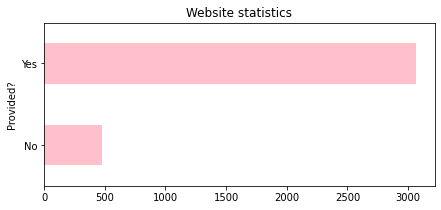

In [96]:
web_chart = corpus_df['Website'].value_counts()
web_chart = web_chart.sort_values(ascending=True)
web_chart.plot(kind="barh", figsize=(7, 3), title='Website statistics', 
                xlabel='Provided?', ylabel='Count', color='pink')

# Releases by year

First we create a copy of our corpus dataset, containing only GAP citations with versions provided, all other entries such as Package citations are removed.

In [97]:
pure_gap = corpus_df.loc[corpus_df["Version"] != 'Package']
pure_gap = pure_gap.loc[pure_gap["Version"] != 'GRAPE GAP Package']
pure_gap = pure_gap[pure_gap.astype(str).ne('None').all(1)] # removing all None rows.
pure_gap

,MR,Citation,Version,Website
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and pro...",4.7.5,Yes
3,MR3354065,"The GAP – Groups, Algorithms and Programming. ...",4.4.12,Yes
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg...",4.7.8,Yes
6,MR2287843,"The GAP Group, GAP - Groups, Algorithms, and P...",4.3,Yes
7,MR2175389,"The GAP Group, GAP-Groups, Algorithms, and pro...",4.3,Yes
...,...,...,...,...
3518,MR2078931,"A. Mathas, Decomposition matrices of Hecke alg...",3.4.4,No
3519,MR1624797,"M. SCHO NERT (ed.), Gap-3.3 manual (RWTH Aache...",3.3,No
3520,MR2143203,"M. Schönert et al., Gap: groups, algorithms, a...",3.4.4,No
3528,MR1695079,"M. Schönert et al., ""Gap: groups, algorithms, ...",3.4.4,No


In [98]:
versions_cited = pure_gap['Version'].unique()

In [99]:
versions_cited

array(['4.7.5', '4.4.12', '4.7.8', '4.3', '4.4', '4.4.4', '4.6.4',
       '4.7.2', '4.6.5', '4.7.9', '4.8.8', '4.8.9', '4.4.10', '4.5.7',
       '4.7.4', '4.7.7', '4.2', '4.6.12', '4.1', '4.10.0', '4.8.6',
       '4.8.2', '4.10.2', '4.11.0', '4.4.2', '4.8.3', '10.1109', '4.8.7',
       '4.6', '2.12', '4.9.1', '4.4.9', '4.8.4', '4.6.2', '1.2', '4.9.3',
       '4.8.10', '4.5', '4.4.6', '4.4.7', '4.5.5', '1.4', '1.3.3',
       '4.4.11', '5.7', '1.5.4', '4.10.1', '1.0.0', '4.4.10.2007',
       '4.6.3', '1405.5063', '1.1', '3.4', '4.8.5', '4.5.6', '4.11',
       '4.10', '4.9.2', '4.7.6', '4.6.9', '4.5.4', '3.4.4', '4.08.10',
       '0710.3267', '0911.5589', '1.2.2', '1.5.1', '4.8', '4.9.0', '4.7',
       '3.3', '2.19', '0.97', '10.14760', '1.2.1', '2.2.0', '3.0',
       '2.0.0', '4.4.2006', '4.5.3', '2.1.0', '3.1.0', '3.4.3', '1.0',
       '55.0810.04', '4.6.1', '4.4.3', '1.1.3', '4.8.1', '1.9.6',
       '1804.09707', '3.1', '4.4.5', '1.4.0', '4.46', '4.9', '4.49',
       '10.01.16', '3.2']

In [100]:
release_dates = { 
    # dates from archive timestamps
    '4.8.2': 2016, # 2016/02/20
    '4.7.9': 2015, # 2015/11/29
    '4.7.8': 2015, # 2015/06/09
    '4.7.7': 2015, # 2015/02/13
    '4.7.6': 2014, # 2014/11/15
    '4.7.5': 2014, # 2014/05/24
    '4.7.4': 2014, # 2014/02/20
    '4.7.3': 2013, # 2014/02/15
    '4.7.2': 2013, # 2013/12/01
    '4.7': 2013,
    '4.6.5': 2013, # 2013/07/20
    '4.6.4': 2013, # 2013/05/04
    '4.6.3': 2013, # 2013/03/18
    '4.6.2': 2013, # 2013/02/02
    '4.5.7': 2012, # 2012/12/14
    '4.5.6': 2012, # 2012/09/16
    '4.5.5': 2012, # 2012/07/16
    '4.5.4': 2012, # 2013/06/04
    '4.5': 2012, 
    # dates below from file creation
    '4.4.12': 2008, # 2008/12/16
    '4.4.11': 2008, # 2008/12/08
    '4.4.10': 2007, # 2007/10/05
    '4.4.9': 2006,  # 2006/11/02
    '4.4.8': 2006,  # 2006/09/29
    '4.4.7': 2006,  # 2006/03/17
    '4.4.6': 2005,  # 2005/09/02
    '4.4.5': 2005,  # 2005/05/13
    '4.4.4': 2004,  # 2004/12/22
    # dates below from http://www.gap-system.org/Download/Updates/index.html
    '4.4.3': 2004,   # May 2004
    '4.4.2': 2004,  # April 2004
    # dates from http://www.gap-system.org/Doc/History/history.html
    # if not stated otherwise
    '4.4': 2004, 
    '4.3': 2002, 
    '4.2': 2000, # http://www.gap-system.org/ForumArchive/Linton.1/Steve.1/Release_.3/1.html
    '4.1': 1999, 
    '3.4': 1997, # assume http://www.gap-system.org/Doc/History/preface_3.4.4.html
}

In [ ]:
release_dates.keys()

In [101]:
def release_year(version):
    if version in release_dates.keys():
        return release_dates[version]
    else:
        return 'Unknown'

In [102]:
release_year('4.7.2')

2013

In [103]:
corpus_df['ReleaseYear'] = corpus_df['Version'].map(release_year)

In [104]:
data = corpus_df['ReleaseYear'].value_counts()

* Number of Citations by year of cited GAP release, in textual and graphic forms.

In [105]:
data

Unknown    1682
2004        464
2008        314
2002        212
2007        136
2000        126
2014        122
2013        114
2015        109
2006         92
2012         86
1999         32
1997         30
2005         13
2016         10
Name: ReleaseYear, dtype: int64

<AxesSubplot:title={'center':'Citations by year of cited GAP release'}, xlabel='Years', ylabel='Count'>

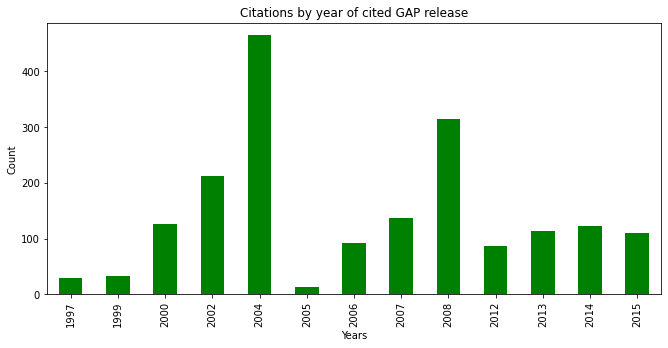

In [106]:
data.loc[sorted(data.index.intersection(range(1997, 2016)))].plot(kind="bar", 
                figsize=(11, 5), title='Citations by year of cited GAP release', xlabel='Years', 
                ylabel='Count', color='green')

all_years = corpus_df.groupby(['year','ReleaseYear'])['Year'].count()
all_years

In [ ]:
get_citation('MR2592492')

# Merging the two dataframes with the equivalent of SQL `join`

df = pd.DataFrame(lis_dic)
df = df[df.ID.isin(targets)]
df_filtered = df[df.mrnumber.isin(mrs)]

The `MR` column in `corpus_df` dataframe has the letters "MR" preceeding each number, first we will remove these letters, the the MR number format is the same in both datasets.

In [107]:
corpus_df['MR'] = corpus_df['MR'].str.extract('(\d+)', expand=False)
corpus_df

,MR,Citation,Version,Website,ReleaseYear
0,4056124,"GAP – Groups, algorithms, programming - a syst...",None,Yes,Unknown
1,3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.:...",Package,Yes,Unknown
2,3942387,"The GAP Group: GAP—groups, algorithms, and pro...",4.7.5,Yes,2014
3,3354065,"The GAP – Groups, Algorithms and Programming. ...",4.4.12,Yes,2008
4,3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg...",4.7.8,Yes,2015
...,...,...,...,...,...
3537,3988630,"M. Delgado, P. A. García-Sánchez and J. Morais...",Package,Yes,Unknown
3538,1801202,"L.H. Soicher, GRAPE: a system for computing wi...",GRAPE GAP Package,Yes,Unknown
3539,2558870,"L. Bartholdi, Functionally recursive groups, h...",None,Yes,Unknown
3540,2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality g...",None,Yes,Unknown


In [127]:
corpus_df.describe()

,MR,Citation,Version,Website,ReleaseYear
count,3542,3542,3004,3542,3542
unique,2795,3348,101,2,15
top,3197178,"The GAP Group, GAP—Groups, Algorithms, and Pro...",Package,Yes,Unknown
freq,7,8,730,3067,1682


In [128]:
bib_df.describe()

,MR,author,journal,year,ENTRYTYPE
count,3159,3367,3047,3363,3367
unique,3158,2511,384,35,10
top,3656296,"Eick, B.",J. Algebra,2017,article
freq,2,18,387,188,2976


* With the following code we are joining the two datasets on the `MR` column and using `corpus_df` as a base. The resulting dataset will have as many lines as `corpus_df` but all columns from `bib_df` will be added, hence we will have much more information to work with.

In [120]:
merged_df = pd.merge(bib_df, corpus_df, on='MR', how='right', indicator=True)
merged_df

,MR,author,journal,year,ENTRYTYPE,Citation,Version,Website,ReleaseYear,_merge
0,4056124,"Abas, M. and Vetrík, T.",Theoret. Comput. Sci.,2020,article,"GAP – Groups, algorithms, programming - a syst...",None,Yes,Unknown,both
1,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...,2019,article,"Delgado, M., García-Sánchez, P.A., Morais, J.:...",Package,Yes,Unknown,both
2,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...,2019,article,"The GAP Group: GAP—groups, algorithms, and pro...",4.7.5,Yes,2014,both
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015,article,"The GAP – Groups, Algorithms and Programming. ...",4.4.12,Yes,2008,both
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and ...",J. Pure Appl. Algebra,2017,article,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg...",4.7.8,Yes,2015,both
...,...,...,...,...,...,...,...,...,...,...
3538,3988630,"Rosales, J. C. and Branco, M. B.",Proc. Roy. Soc. Edinburgh Sect. A,2019,article,"M. Delgado, P. A. García-Sánchez and J. Morais...",Package,Yes,Unknown,both
3539,1801202,"Shaw, R.",Des. Codes Cryptogr.,2000,incollection,"L.H. Soicher, GRAPE: a system for computing wi...",GRAPE GAP Package,Yes,Unknown,both
3540,2558870,"Sidki, S. N.",J. Algebra,2009,article,"L. Bartholdi, Functionally recursive groups, h...",None,Yes,Unknown,both
3541,2824780,"Tian, Y. and Lu, C.",J. Ind. Manag. Optim.,2011,article,"X. Sun, C. Liu, D. Li and J. Gao, On duality g...",None,Yes,Unknown,both


In [216]:
merged_df = merged_df.drop(['_merge'], axis=1)

* Year

In [226]:
all_years = merged_df.groupby(['year','ReleaseYear'])['year'].count()
all_years = pd.DataFrame(data=all_years)
all_years

year
year ReleaseYear      
1992 Unknown         1
1993 Unknown         2
1994 Unknown         1
1997 1997            5
     Unknown        15
...                ...
2020 2015            7
     Unknown       171
2021 2014            1
     2015            2
     Unknown        47

[172 rows x 1 columns]

# Visualisations

IndexError: list index out of range

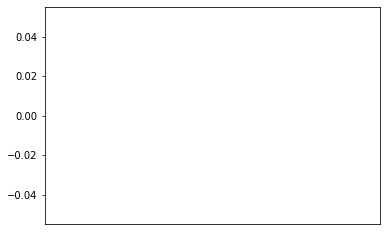

In [228]:
from pandas.plotting import parallel_coordinates

parallel_coordinates(all_years, "year")

In [135]:
site_year = merged_df.groupby('Website').count()
site_year

,MR,author,journal,year,ENTRYTYPE,Citation,Version,ReleaseYear,_merge
Website,,,,,,,,,
No,475,475,455,475,475,475,244,475,475
Yes,3068,3061,2985,3056,3061,3068,2760,3068,3068


* Most citations are around 110 characters long.

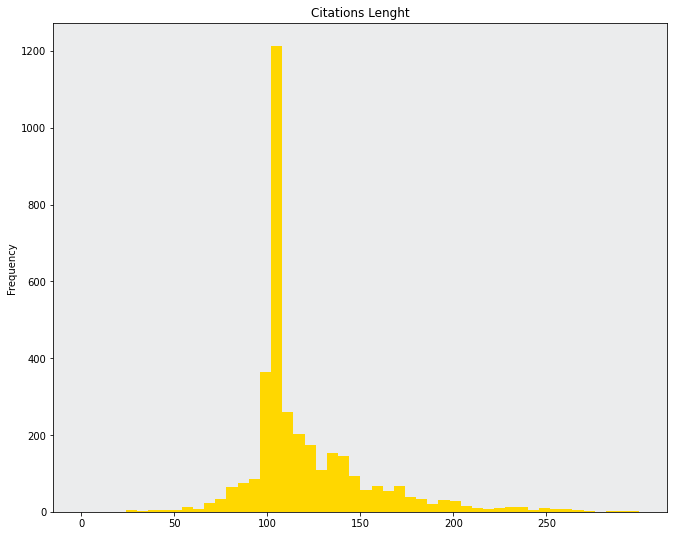

In [192]:
merged_df['lentght'] = merged_df['Citation'].apply(len)
cit_len = merged_df['lentght'].plot(kind='hist', bins=50, figsize=(11,9), stacked=True, 
                         xticks = range(0, 300, 50), 
                         range=(0, 300), 
                         color='gold', 
                         title='Citations Lenght', 
                         xlabel="lenght")
cit_len.set_facecolor('#ebeced')


In [229]:
merged_df

,MR,author,journal,year,ENTRYTYPE,Citation,Version,Website,ReleaseYear,lentght
0,4056124,"Abas, M. and Vetrík, T.",Theoret. Comput. Sci.,2020,article,"GAP – Groups, algorithms, programming - a syst...",None,Yes,Unknown,104
1,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...,2019,article,"Delgado, M., García-Sánchez, P.A., Morais, J.:...",Package,Yes,Unknown,183
2,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...,2019,article,"The GAP Group: GAP—groups, algorithms, and pro...",4.7.5,Yes,2014,125
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015,article,"The GAP – Groups, Algorithms and Programming. ...",4.4.12,Yes,2008,87
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and ...",J. Pure Appl. Algebra,2017,article,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg...",4.7.8,Yes,2015,111
...,...,...,...,...,...,...,...,...,...,...
3538,3988630,"Rosales, J. C. and Branco, M. B.",Proc. Roy. Soc. Edinburgh Sect. A,2019,article,"M. Delgado, P. A. García-Sánchez and J. Morais...",Package,Yes,Unknown,167
3539,1801202,"Shaw, R.",Des. Codes Cryptogr.,2000,incollection,"L.H. Soicher, GRAPE: a system for computing wi...",GRAPE GAP Package,Yes,Unknown,327
3540,2558870,"Sidki, S. N.",J. Algebra,2009,article,"L. Bartholdi, Functionally recursive groups, h...",None,Yes,Unknown,102
3541,2824780,"Tian, Y. and Lu, C.",J. Ind. Manag. Optim.,2011,article,"X. Sun, C. Liu, D. Li and J. Gao, On duality g...",None,Yes,Unknown,158


In [235]:
year_df = merged_df.sort_values(by='year', ascending=False)
year_df.dropna()
num = year_df['journal'].count()
year_df.plot(x='year', y=num, kind='barh')


IndexError: index 3440 is out of bounds for axis 0 with size 10

ValueError: Invalid color burgundy

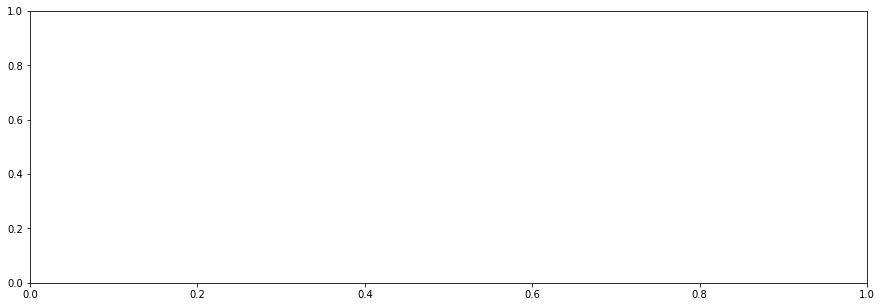

In [245]:
ver = merged_df['Version'].value_counts()
ver = ver.head(50)
ver = ver.to_frame()
ver = ver.sort_index()
ver = ver.dropna()
ver.plot(kind="barh", figsize=(15, 5), title='Top 50 most cited GAP versions', xlabel='Version', 
                ylabel='Count', color='burgundy')

In [243]:
merged_df['Version'].value_counts()

Package    730
4.4        454
4.4.12     310
4.3        212
4.4.10     136
          ... 
4.08.10      1
1.9.6        1
4.46         1
5.7          1
4.6.1        1
Name: Version, Length: 101, dtype: int64